# Part 3: Machine Learning

Modeling part is all about trying different models, tweaking hyperparameters, evaluation, finding creative ways to engineer features and so on.

### Steps:
1. Baseline Model
2. ARIMA
3. Sentiment Analysis
4. Features Selection with XGBoost
5. Deep Neural Networks 
 - 5.1 LSTM Network
 - 5.2 Convolutional Network
 - 5.3 Combined Stocks Data
 - 5.4 Bayesian Optimization
6. Pattern Recognition by Hand
7. Q-Learning

## Importing Libraries

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
import numpy as np
from numpy import array
from importlib import reload # to reload modules if we made changes to them without restarting kernel
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier # for features importance

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227 # native screen dpi for my computer

In [6]:
# ARIMA & SARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

In [9]:
# Tensorflow 2.0 includes Keras
import tensorflow.keras as keras
from tensorflow.python.keras.optimizer_v2 import rmsprop
from functools import partial
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU

# Hyper Parameters Tuning with Bayesian Optimization (> pip install bayesian-optimization)
from bayes_opt import BayesianOptimization

from tensorflow.keras.utils import plot_model

In [10]:
import functions
import plotting

In [11]:
np.random.seed(66)

# Loading Data

Reading stocks' data and keeping it in dictionary **stocks**. `Date` feature becomes index

In [12]:
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    # Include only csv files
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)

# 1. Baseline Model

Baseline model would serve as a benchmark for comparing to more complex models.

In [15]:
def baseline_model(stock):
    '''
    \n\n
    Input: Series or Array
    Returns: Accuracy Score
    Function generates random numbers [0,1] and compares them with true values
    \n\n
    '''
    baseline_predictions = np.random.randint(0, 2, len(stock))
    accuracy = accuracy_score(functions.binary(stock), baseline_predictions)
    return accuracy

### Accuracy

In [16]:
baseline_accuracy = baseline_model(stocks['tsla'].Return)
print('Baseline model accuracy: {:.1f}%'.format(baseline_accuracy * 100))

Baseline model accuracy: 52.1%


### Accuracy Distribution


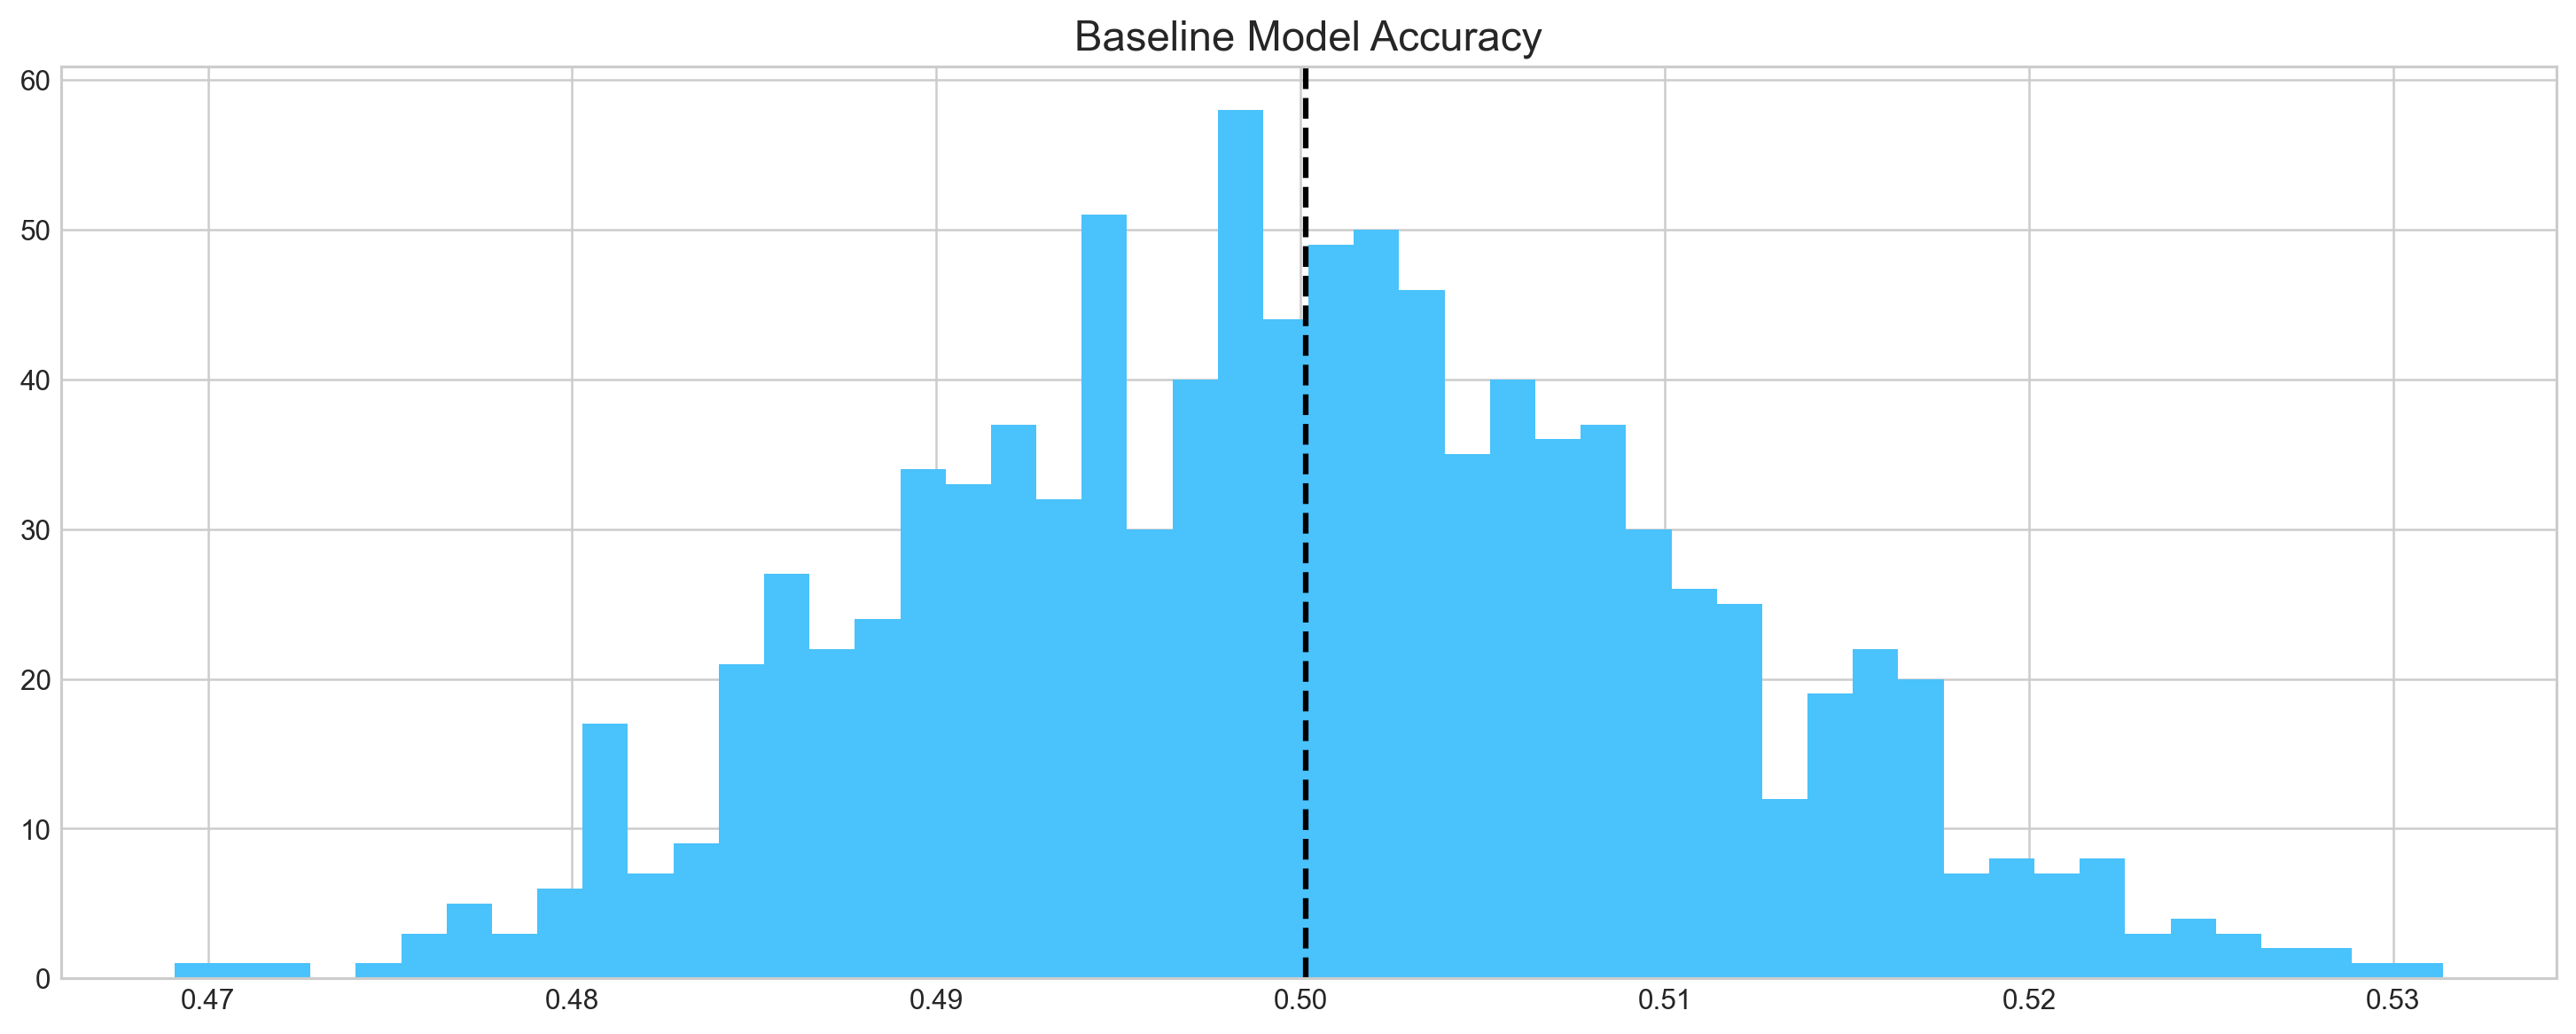

In [17]:
base_preds = []
for i in range(1000):
    base_preds.append(baseline_model(stocks['tsla'].Return))
    
plt.figure(figsize=(16,6))
plt.style.use('seaborn-whitegrid')
plt.hist(base_preds, bins=50, facecolor='#4ac2fb')
plt.title('Baseline Model Accuracy', fontSize=15)
plt.axvline(np.array(base_preds).mean(), c='k', ls='--', lw=2)
plt.show()

### Conclusion

Baseline model on average has 50% accuracy. We take this number as a guideline for our more complex models

# 2. ARIMA

AutoRegressive Integrated Moving Average (ARIMA) is a model that captures a suite of different standard temporal structures in time series data.

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

We will split train and test data to evaluate performance of ARIMA model.

In [18]:
print('Tesla historical data contains {} entries'.format(stocks['tsla'].shape[0]))
stocks['tsla'][['Return']].head()

Tesla historical data contains 2296 entries


Return
Date              
2010-07-28   0.008
2010-07-29  -0.020
2010-07-30  -0.013
2010-08-02   0.020
2010-08-03   0.045

### Autocorrelation

Let's take a look at the `Autocorrelation Function` below. The graph shows how time series **data points** correlate between each other. We should ignore first value in the graph that shows perfect correlation (value = 1), because it tells how **data point** is correlated to itself. What's important in this graph is how **first** data point is correlated to **second**, **third** and so on. We can see that it's so weak, it's close to zero. What does it mean to our analysis? It means that ARIMA is pretty much useless here, because it uses previous data points to predict following.

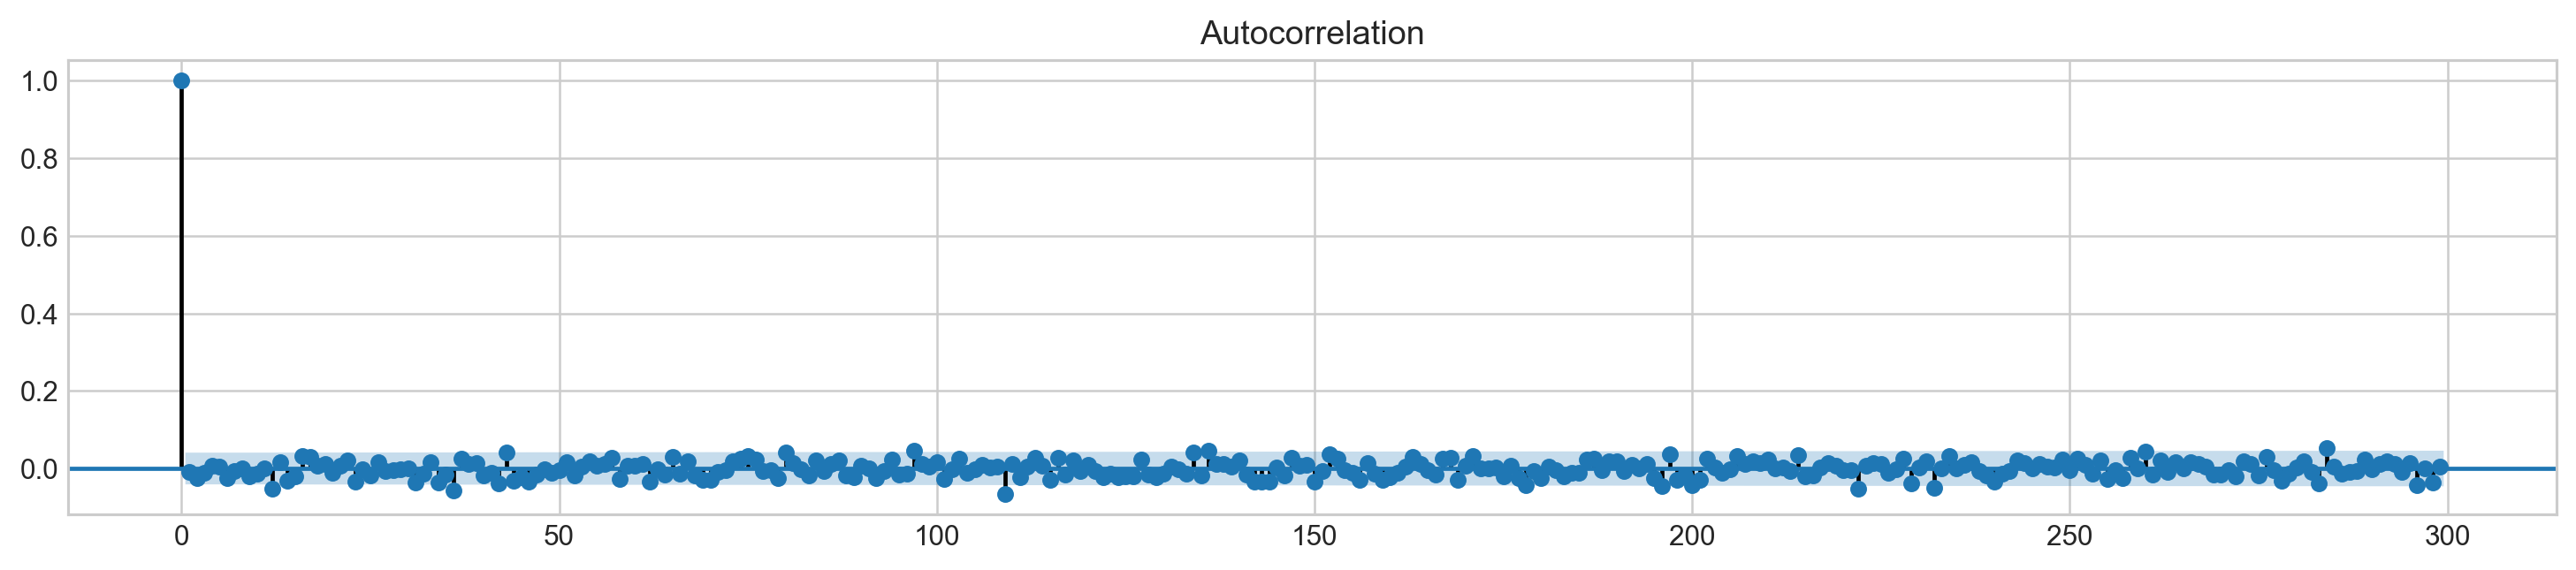

In [19]:
plt.rcParams['figure.figsize'] = (16, 3)
plot_acf(stocks['tsla'].Return, lags=range(300))
plt.show()

To make a conclusion we're going to try different orders and see how well they perform on a given data.

In [20]:
# ARIMA orders
orders = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0)]

# Splitting into train and test sets
train = list(stocks['tsla']['Return'][1000:1900].values)
test = list(stocks['tsla']['Return'][1900:2300].values)

all_predictions = {}

for order in orders:
    
    try:
        # History will contain original train set, 
        # but with each iteration we will add one datapoint
        # from the test set as we continue prediction
        history = train.copy()
        order_predictions = []
        
        for i in range(len(test)):
            
            model = ARIMA(history, order=order) # defining ARIMA model
            model_fit = model.fit(disp=0) # fitting model
            y_hat = model_fit.forecast() # predicting 'return'
            order_predictions.append(y_hat[0][0]) # first element ([0][0]) is a prediction
            history.append(test[i]) # simply adding following day 'return' value to the model    
            print('Prediction: {} of {}'.format(i+1,len(test)), end='\r')
        
        accuracy = accuracy_score( 
            functions.binary(test), 
            functions.binary(order_predictions) 
        )        
        print('                             ', end='\r')
        print('{} - {:.1f}% accuracy'.format(order, round(accuracy, 3)*100), end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(order, '<== Wrong Order', end='\n')
        pass

(0, 0, 0) - 51.5% accuracy   
(1, 0, 0) - 50.8% accuracy   
(0, 1, 0) - 51.3% accuracy   
(0, 0, 1) - 50.8% accuracy   
(1, 1, 0) - 51.8% accuracy   


### Review Predictions

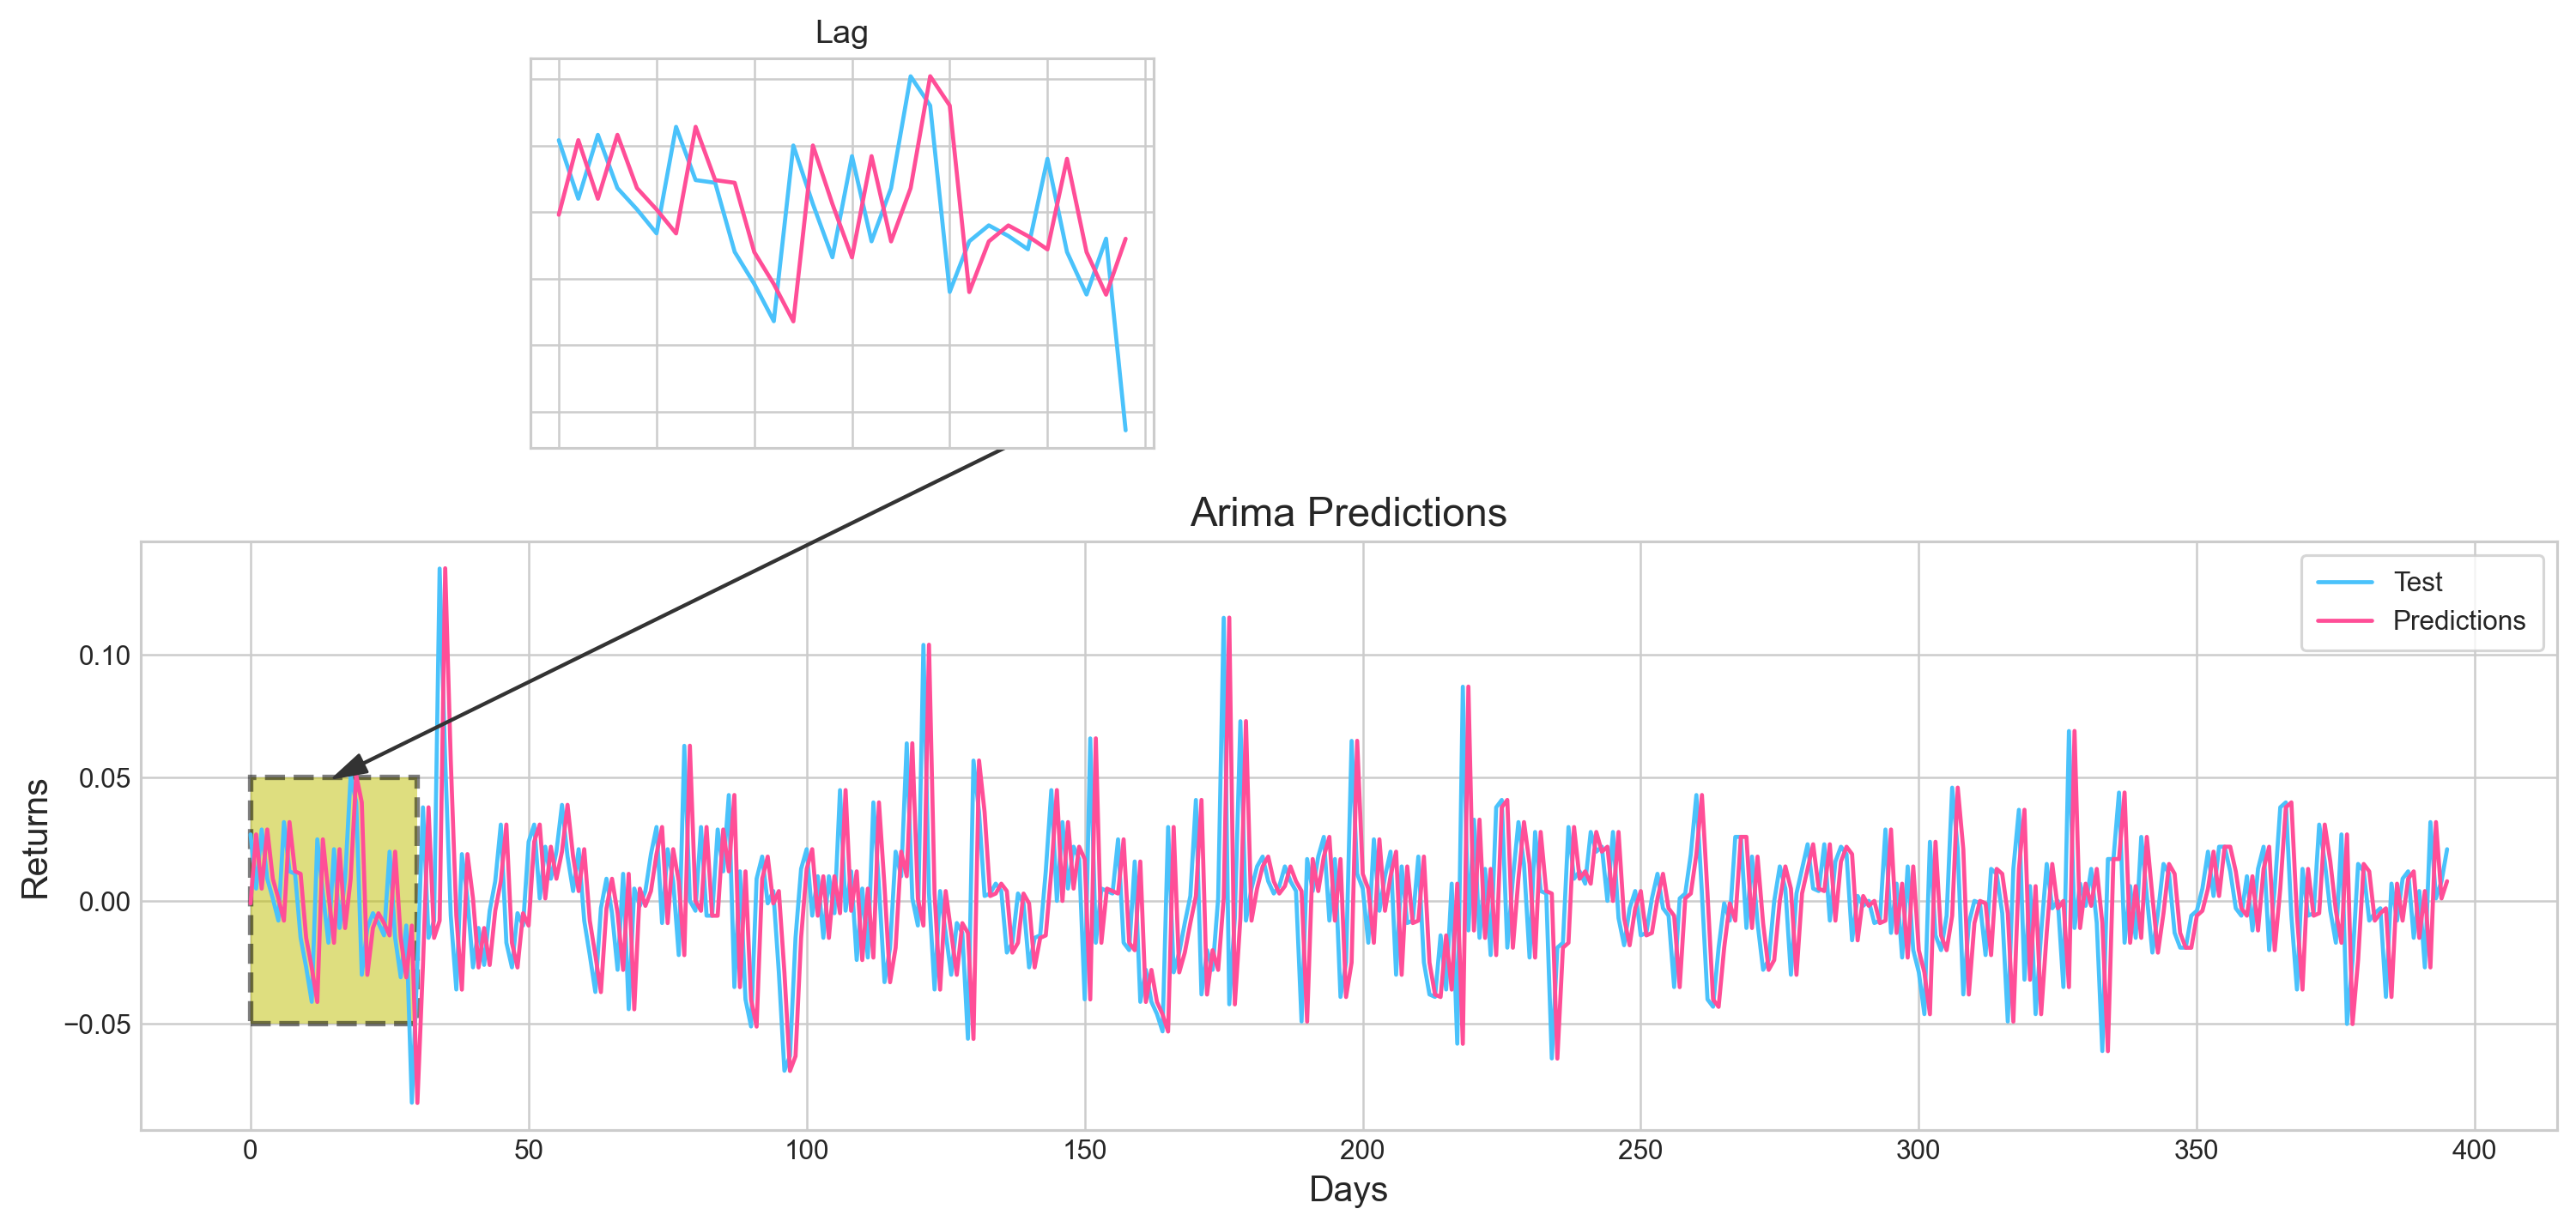

In [21]:
# Big Plot
fig = plt.figure(figsize=(16,4))
plt.plot(test, label='Test', color='#4ac2fb')
plt.plot(all_predictions[(0,1,0)], label='Predictions', color='#ff4e97')
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.title('Arima Predictions', fontSize=15)
plt.xlabel('Days', fontSize=13)
plt.ylabel('Returns', fontSize=13)

# Arrow
plt.annotate('',
             xy=(15, 0.05), 
             xytext=(150, .2), 
             fontsize=10, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'}
            )
# Patch
ax = fig.add_subplot(1, 1, 1)
rect = patches.Rectangle((0,-.05), 30, .1, ls='--', lw=2, facecolor='y', edgecolor='k', alpha=.5)
ax.add_patch(rect)

# Small Plot
plt.axes([.25, 1, .2, .5])
plt.plot(test[:30], color='#4ac2fb')
plt.plot(all_predictions[(0,1,0)][:30], color='#ff4e97')
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Lag')
plt.show()

### Histogram

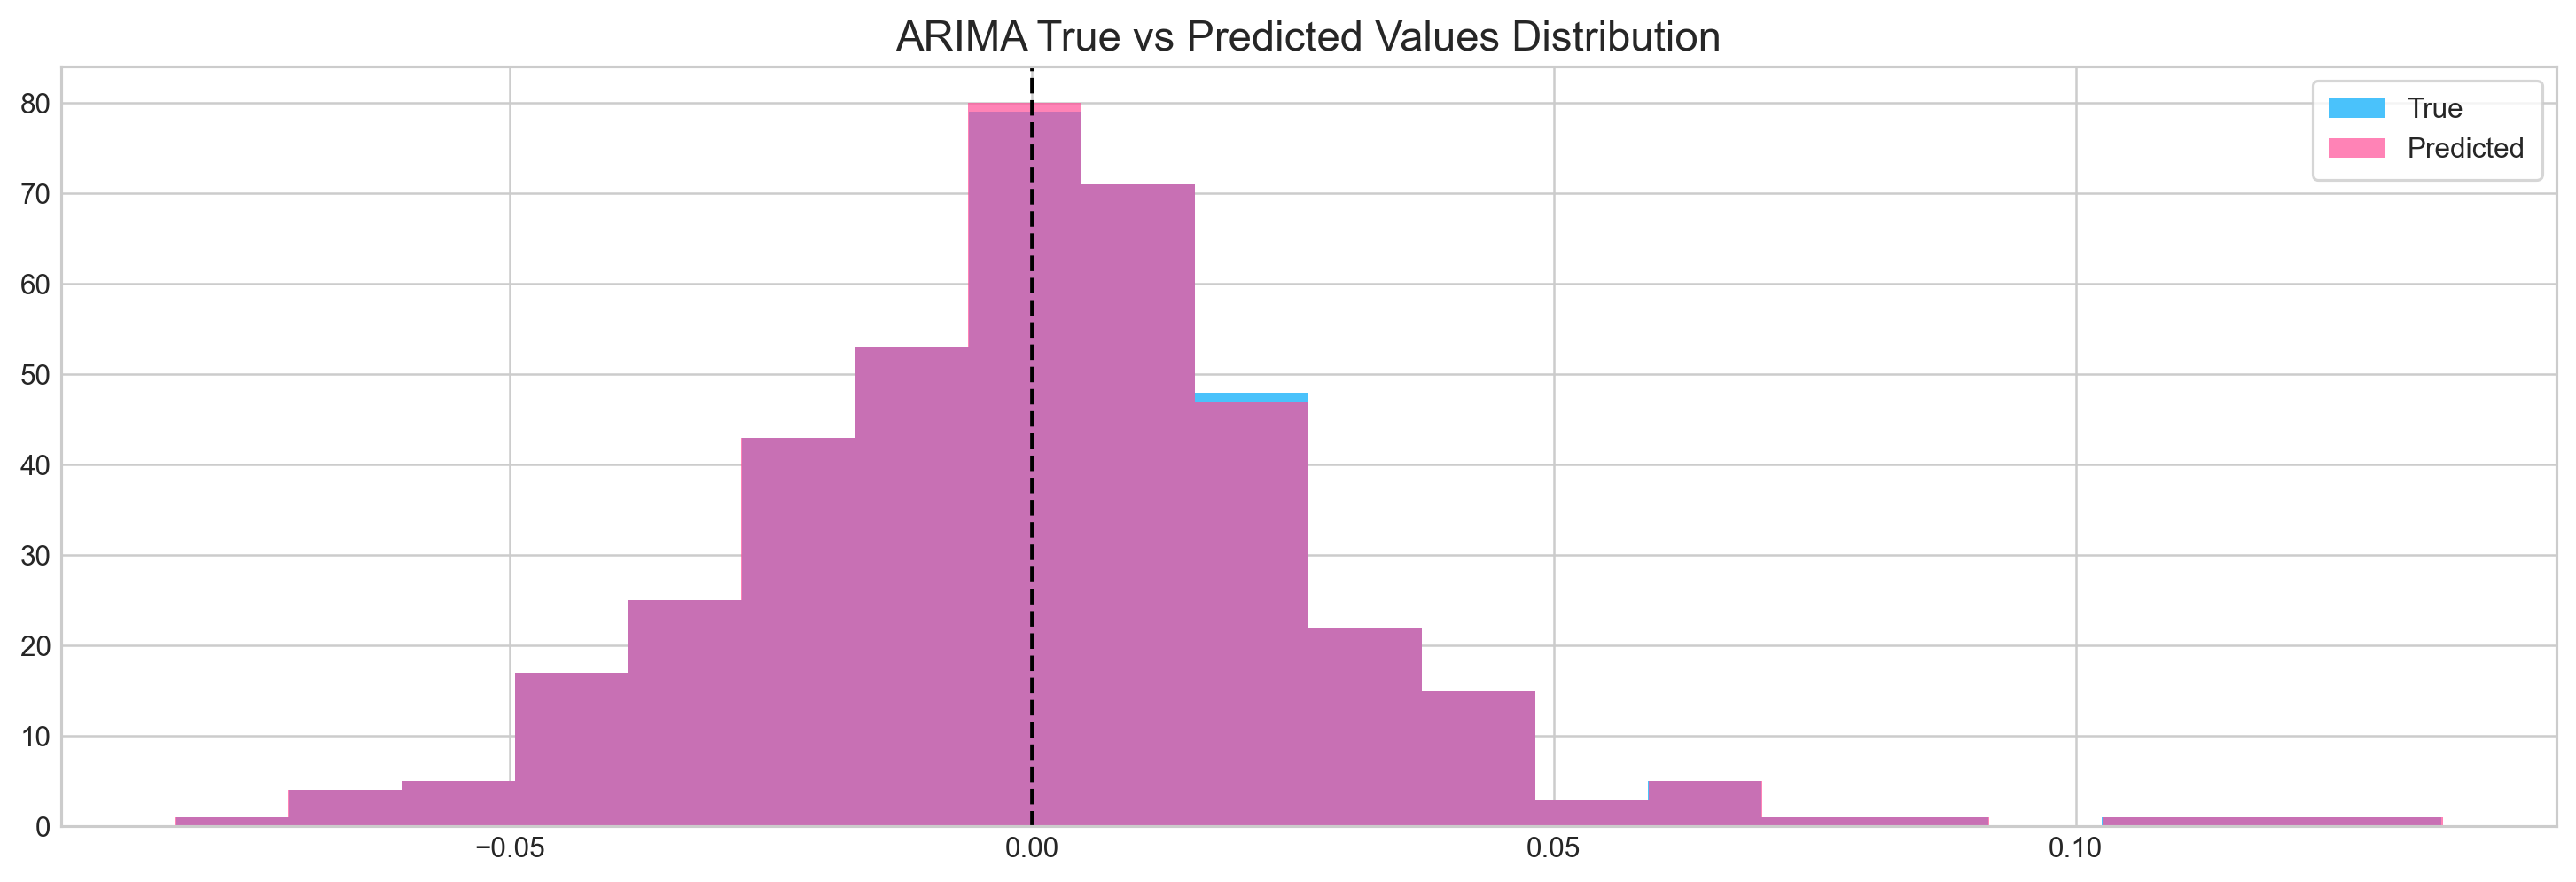

In [23]:
plt.figure(figsize=(16,5))
plt.hist(stocks['tsla'][1900:2300].reset_index().Return, bins=20, label='True', facecolor='#4ac2fb')
plt.hist(all_predictions[(0,1,0)], bins=20, label='Predicted', facecolor='#ff4e97', alpha=.7)
plt.axvline(0, c='k', ls='--')
plt.title('ARIMA True vs Predicted Values Distribution', fontSize=15)
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.show()

### Interpreting Results

In [22]:
test_binary = functions.binary(stocks['tsla'][1900:2300].reset_index().Return)
train_binary = functions.binary(all_predictions[(0,1,0)])
tn, fp, fn, tp = confusion_matrix(test_binary, train_binary).ravel()
accuracy = accuracy_score(test_binary, train_binary)

print("True positive and Negative: {}".format((tp + tn)))
print("False Positive and Negative: {}".format((fp + fn)))
print("Accuracy: {:.1f}%".format(accuracy*100))

True positive and Negative: 203
False Positive and Negative: 193
Accuracy: 51.3%


# 3. Sentiment Analysis

Idea here is to use news sentiment to predict returns next day

In [25]:
tesla_headlines = pd.read_csv('data/tesla_headlines.csv', index_col='Date')

In [26]:
tesla = stocks['tsla'].join(tesla_headlines.groupby('Date').mean().Sentiment)

In [27]:
tesla.fillna(0, inplace=True)

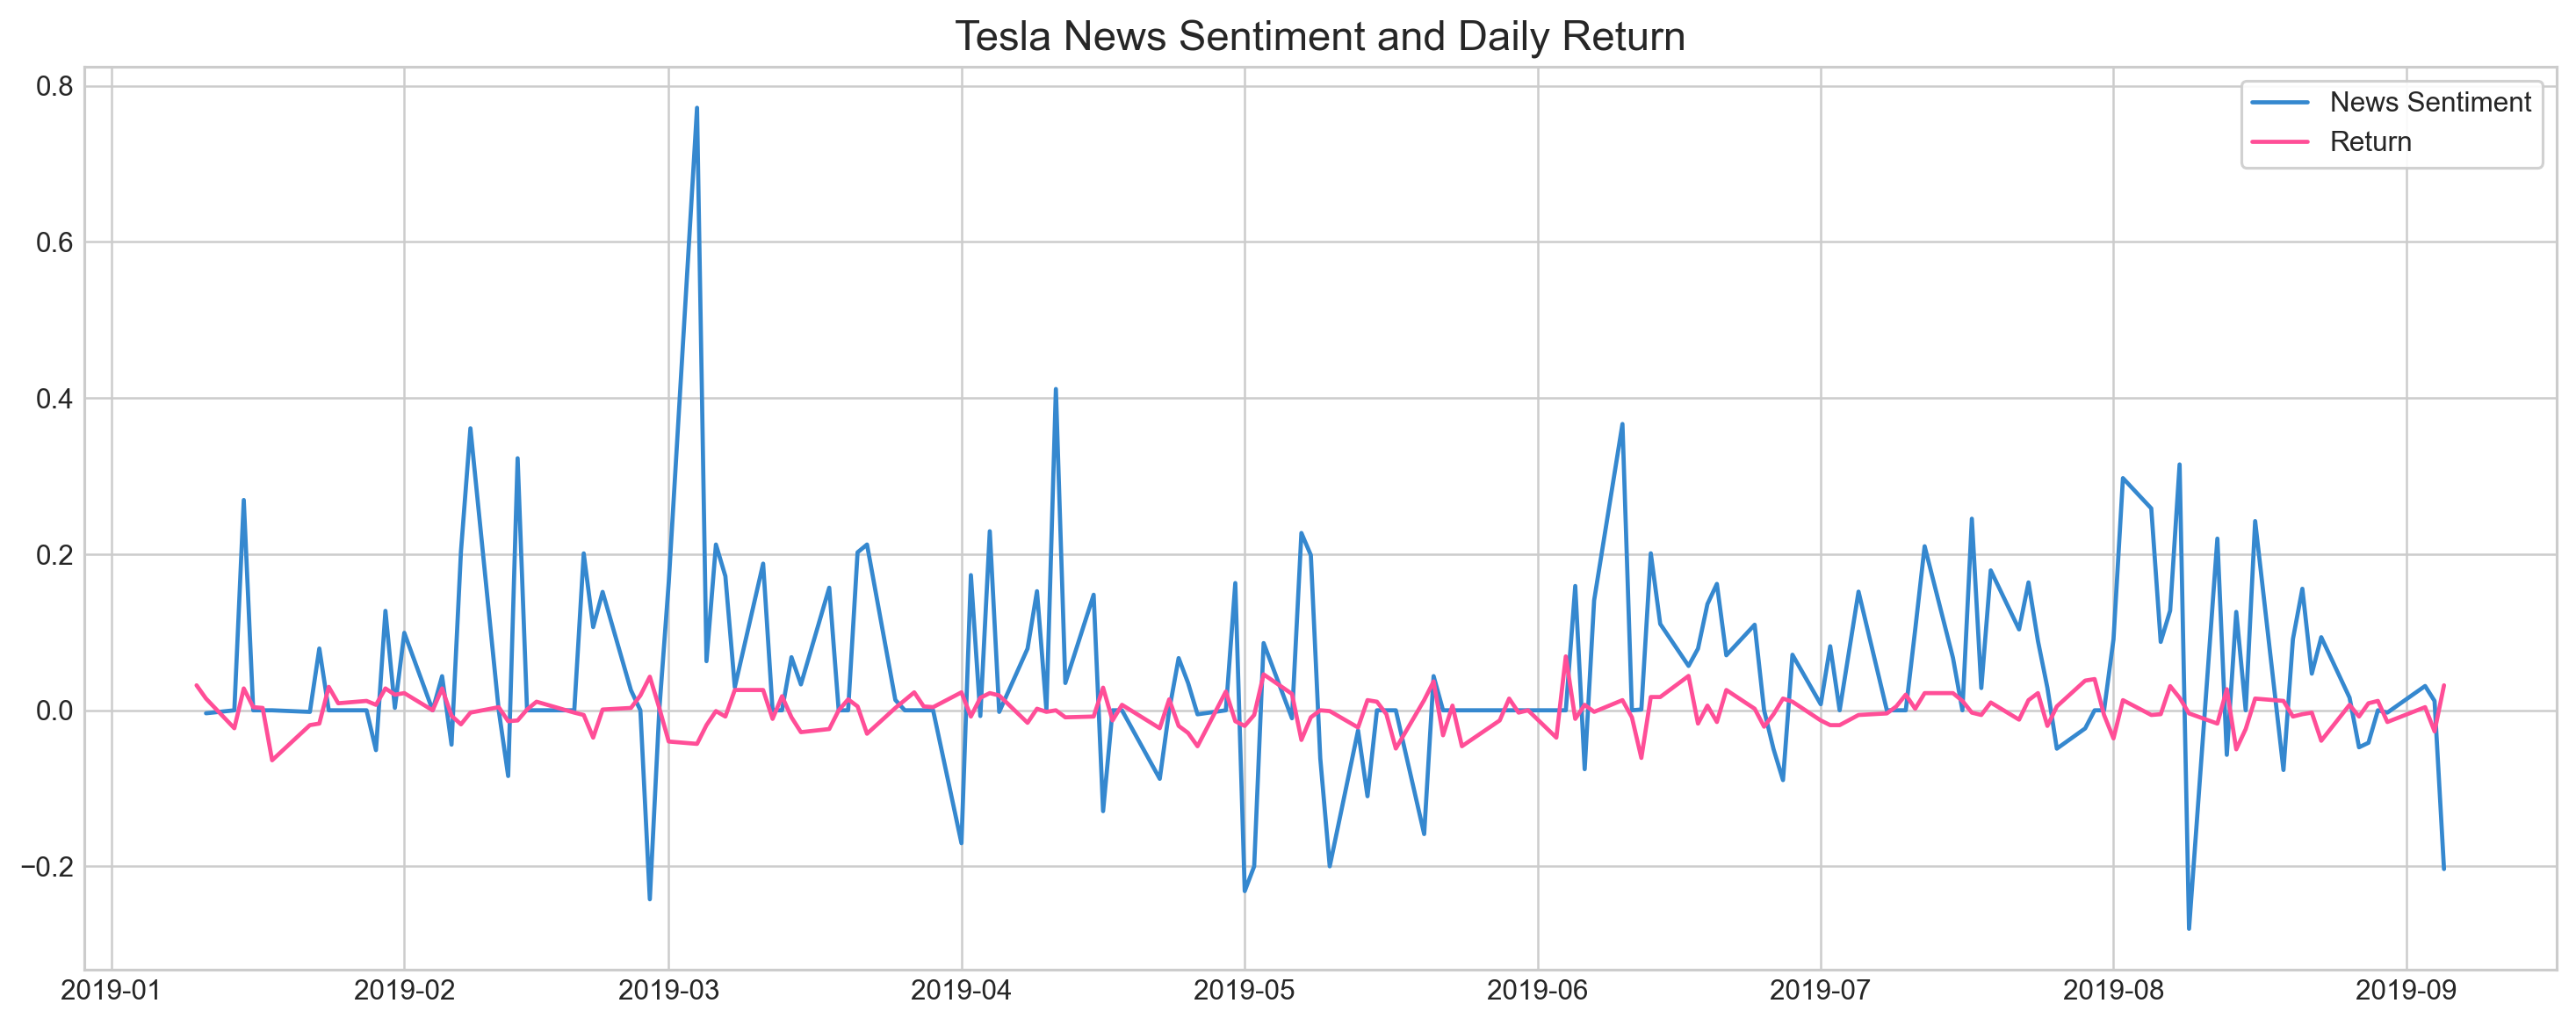

In [28]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,6))
plt.plot(tesla.loc['2019-01-10':'2019-09-05'].Sentiment.shift(1), c='#3588cf', label='News Sentiment')
plt.plot(tesla.loc['2019-01-10':'2019-09-05'].Return, c='#ff4e97', label='Return')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Tesla News Sentiment and Daily Return', fontSize=15)
plt.show()

In [29]:
pd.DataFrame({
    'Sentiment': tesla.loc['2019-01-10':'2019-09-05'].Sentiment.shift(1), 
    'Return': tesla.loc['2019-01-10':'2019-09-05'].Return}).corr()

Sentiment    Return
Sentiment   1.000000 -0.139348
Return     -0.139348  1.000000

### Conclusion

Correlation between news and price movement is negative. Prices moves in the opposite direction, which is wrong. Positive news suppose to drive prices up, not the opposite way.

# 4. Features selection with XGBoost

XGBoost will be used here to extract important features that will be used for neural networks. This might help to improve model accuracy and boost training. Traning will be performed on scaled `Tesla` dataset.

In [30]:
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

In [31]:
X = scaled_tsla[:-1]
y = stocks['tsla'].Return.shift(-1)[:-1]

In [32]:
# Initializing and fitting a model
xgb = XGBClassifier()
xgb.fit(X[1500:], y[1500:])

[16:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

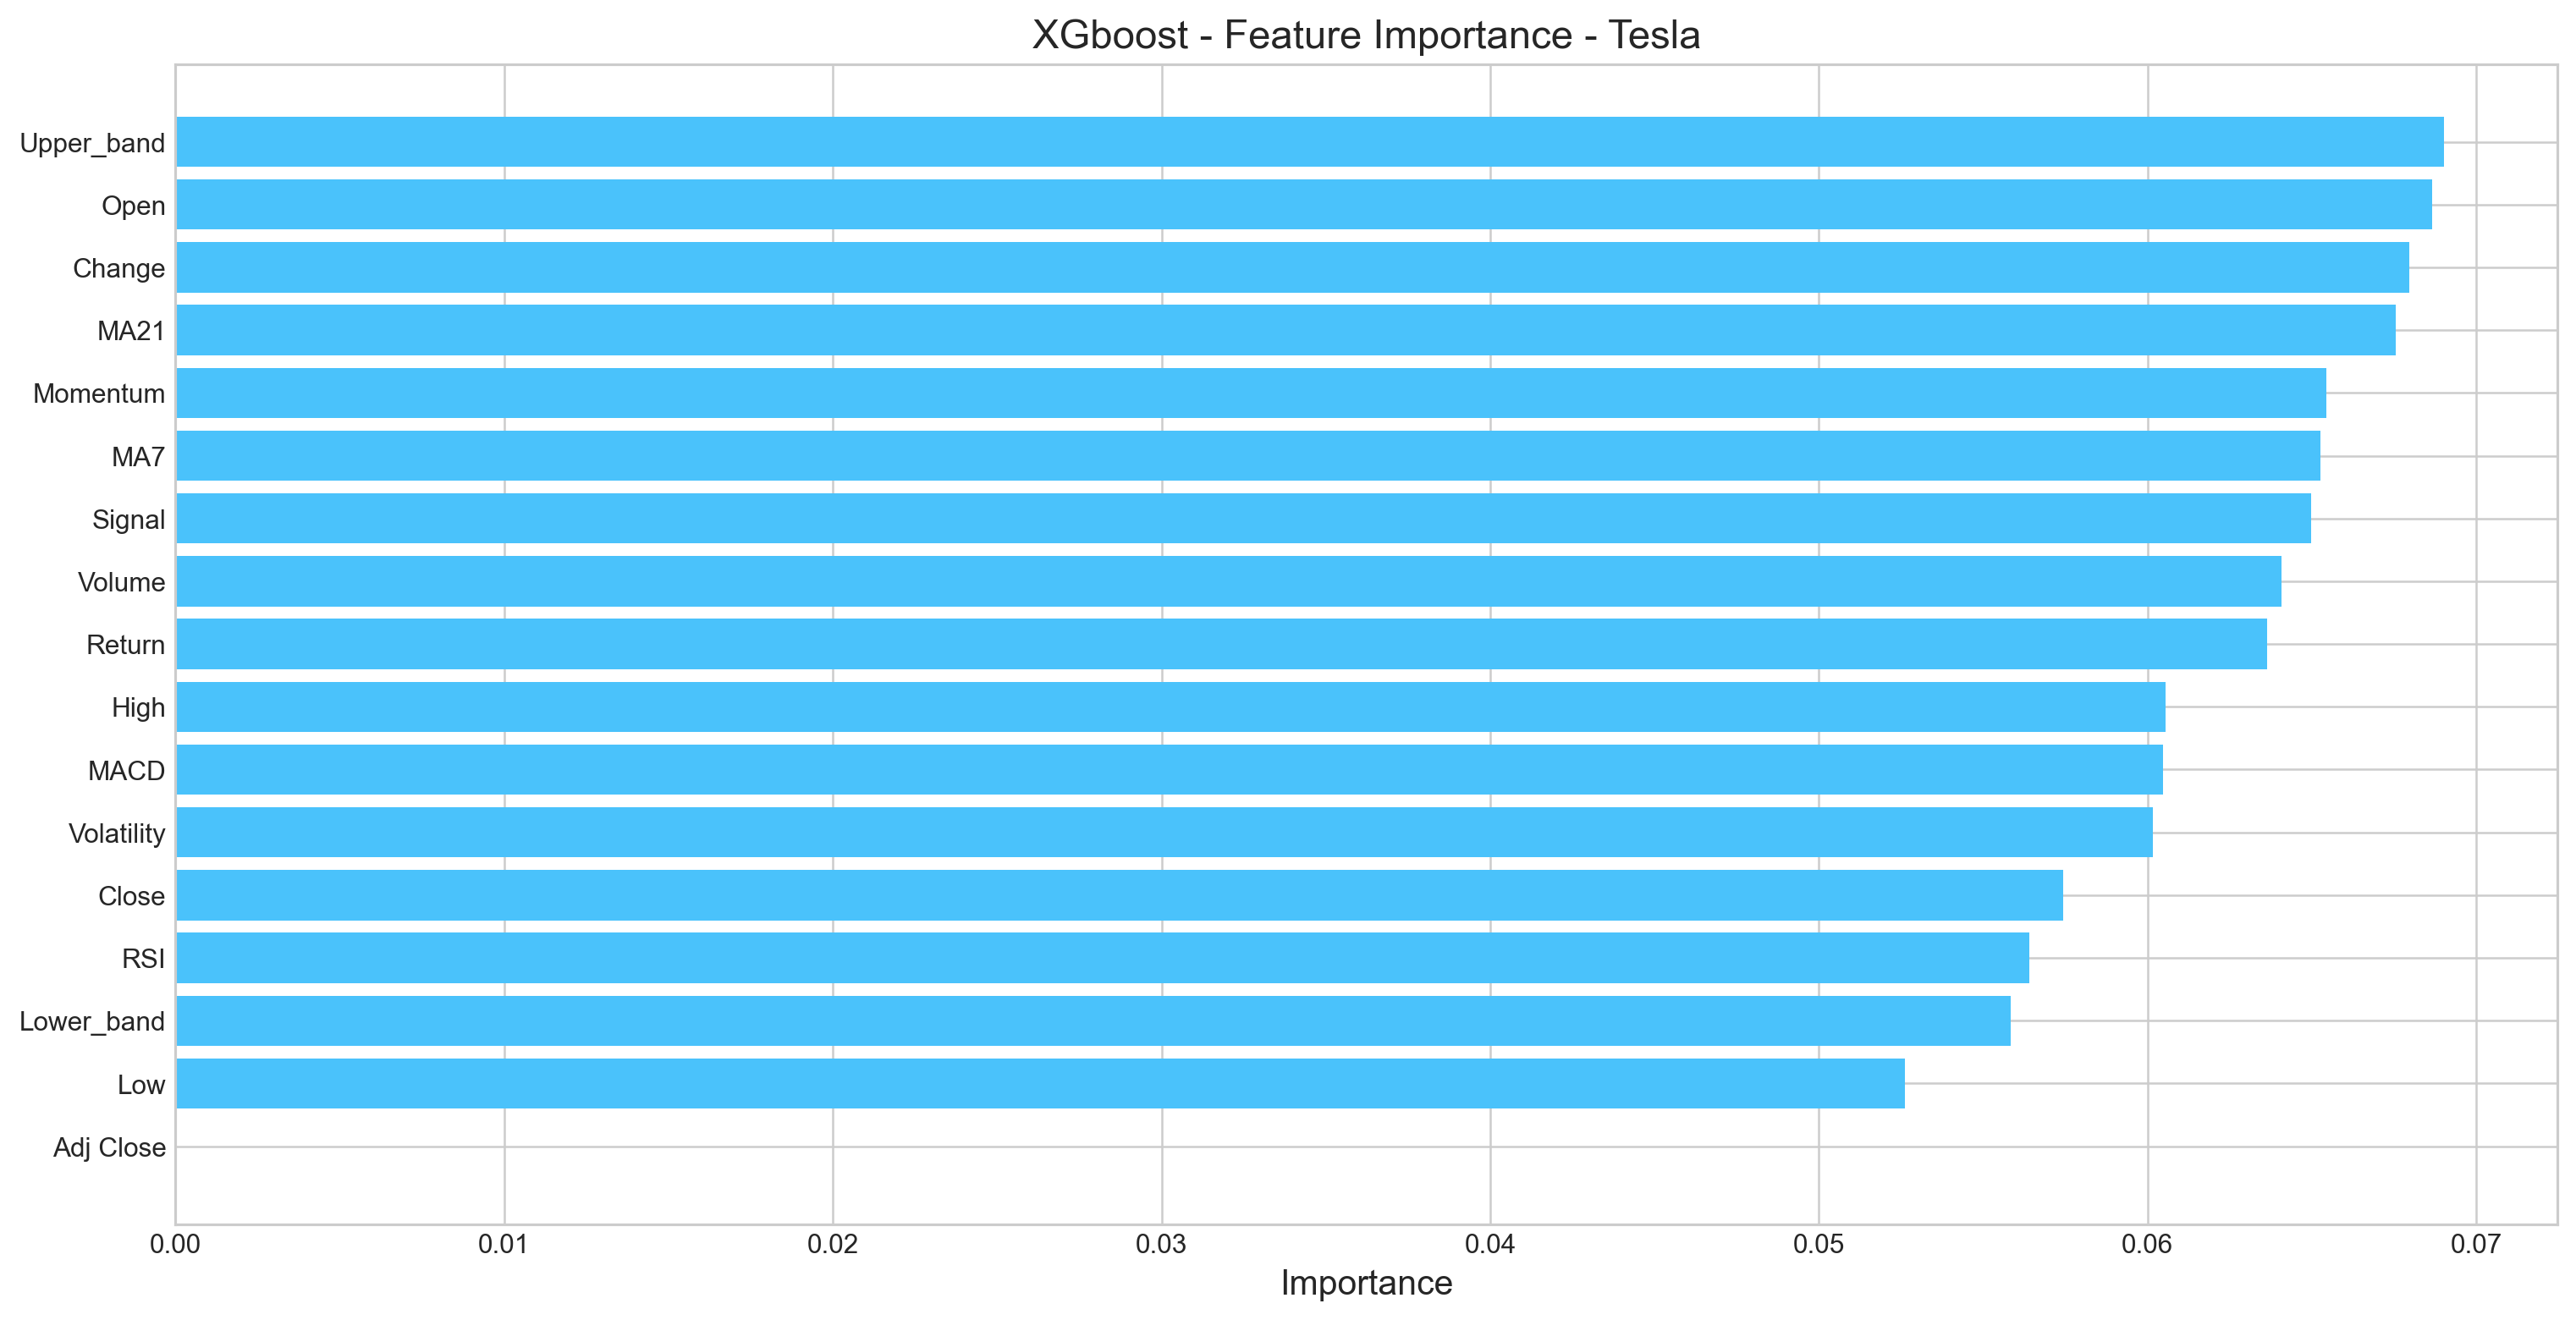

In [33]:
important_features = pd.DataFrame({
                                    'Feature': X.columns, 
                                    'Importance': xgb.feature_importances_}) \
                                    .sort_values('Importance', ascending=True)

plt.figure(figsize=(16,8))
plt.style.use('seaborn-whitegrid')
plt.barh(important_features.Feature, important_features.Importance, color="#4ac2fb")
plt.title('XGboost - Feature Importance - Tesla', fontSize=15)
plt.xlabel('Importance', fontSize=13)
plt.show()

# 5. Deep Neural Networks


## Preparing Data

In [34]:
n_steps = 21
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

X_train, \
y_train, \
X_test, \
y_test = functions.split_sequences(
                        
    scaled_tsla.to_numpy()[:-1], 
    stocks['tsla'].Return.shift(-1).to_numpy()[:-1], 
    n_steps, 
    split=True, 
    ratio=0.8
)

## 5.1 LSTM Network

In [59]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 100)           47200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 77,921
Trainable params: 77,921
Non-trainable params: 0
_________________________________________________________________


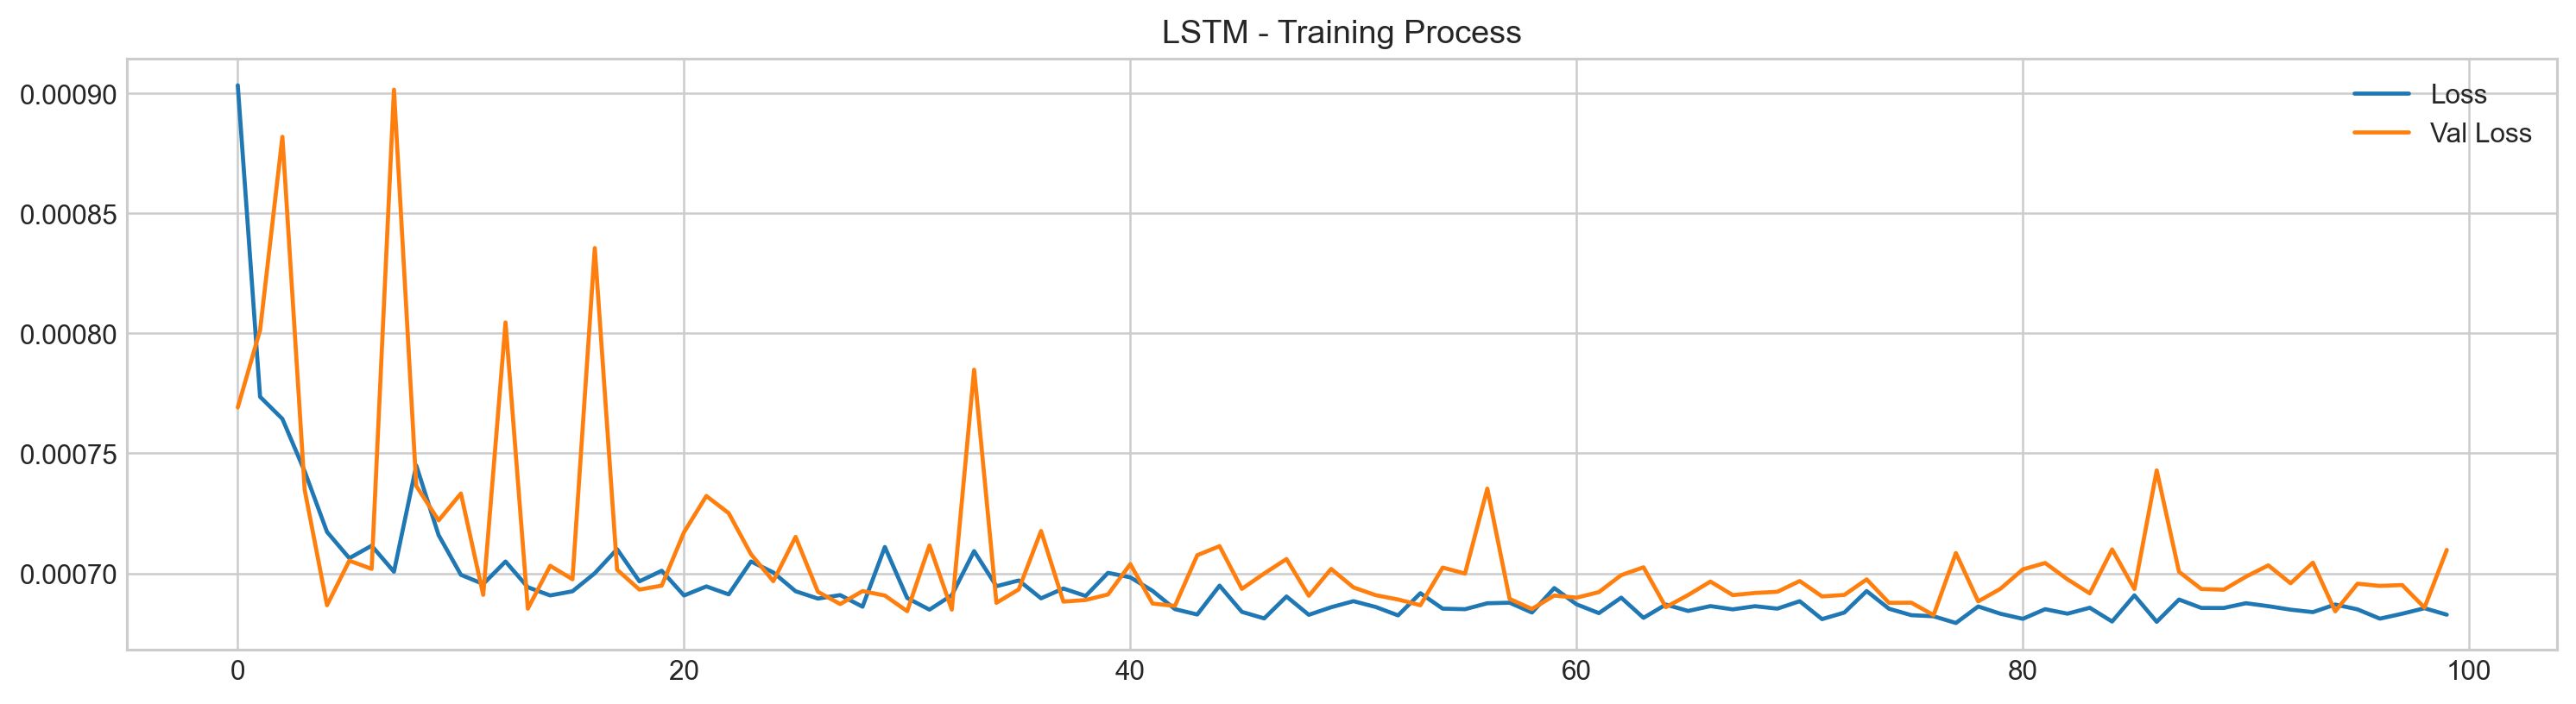

In [61]:
model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test), use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.title('LSTM - Training Process')
plt.show()


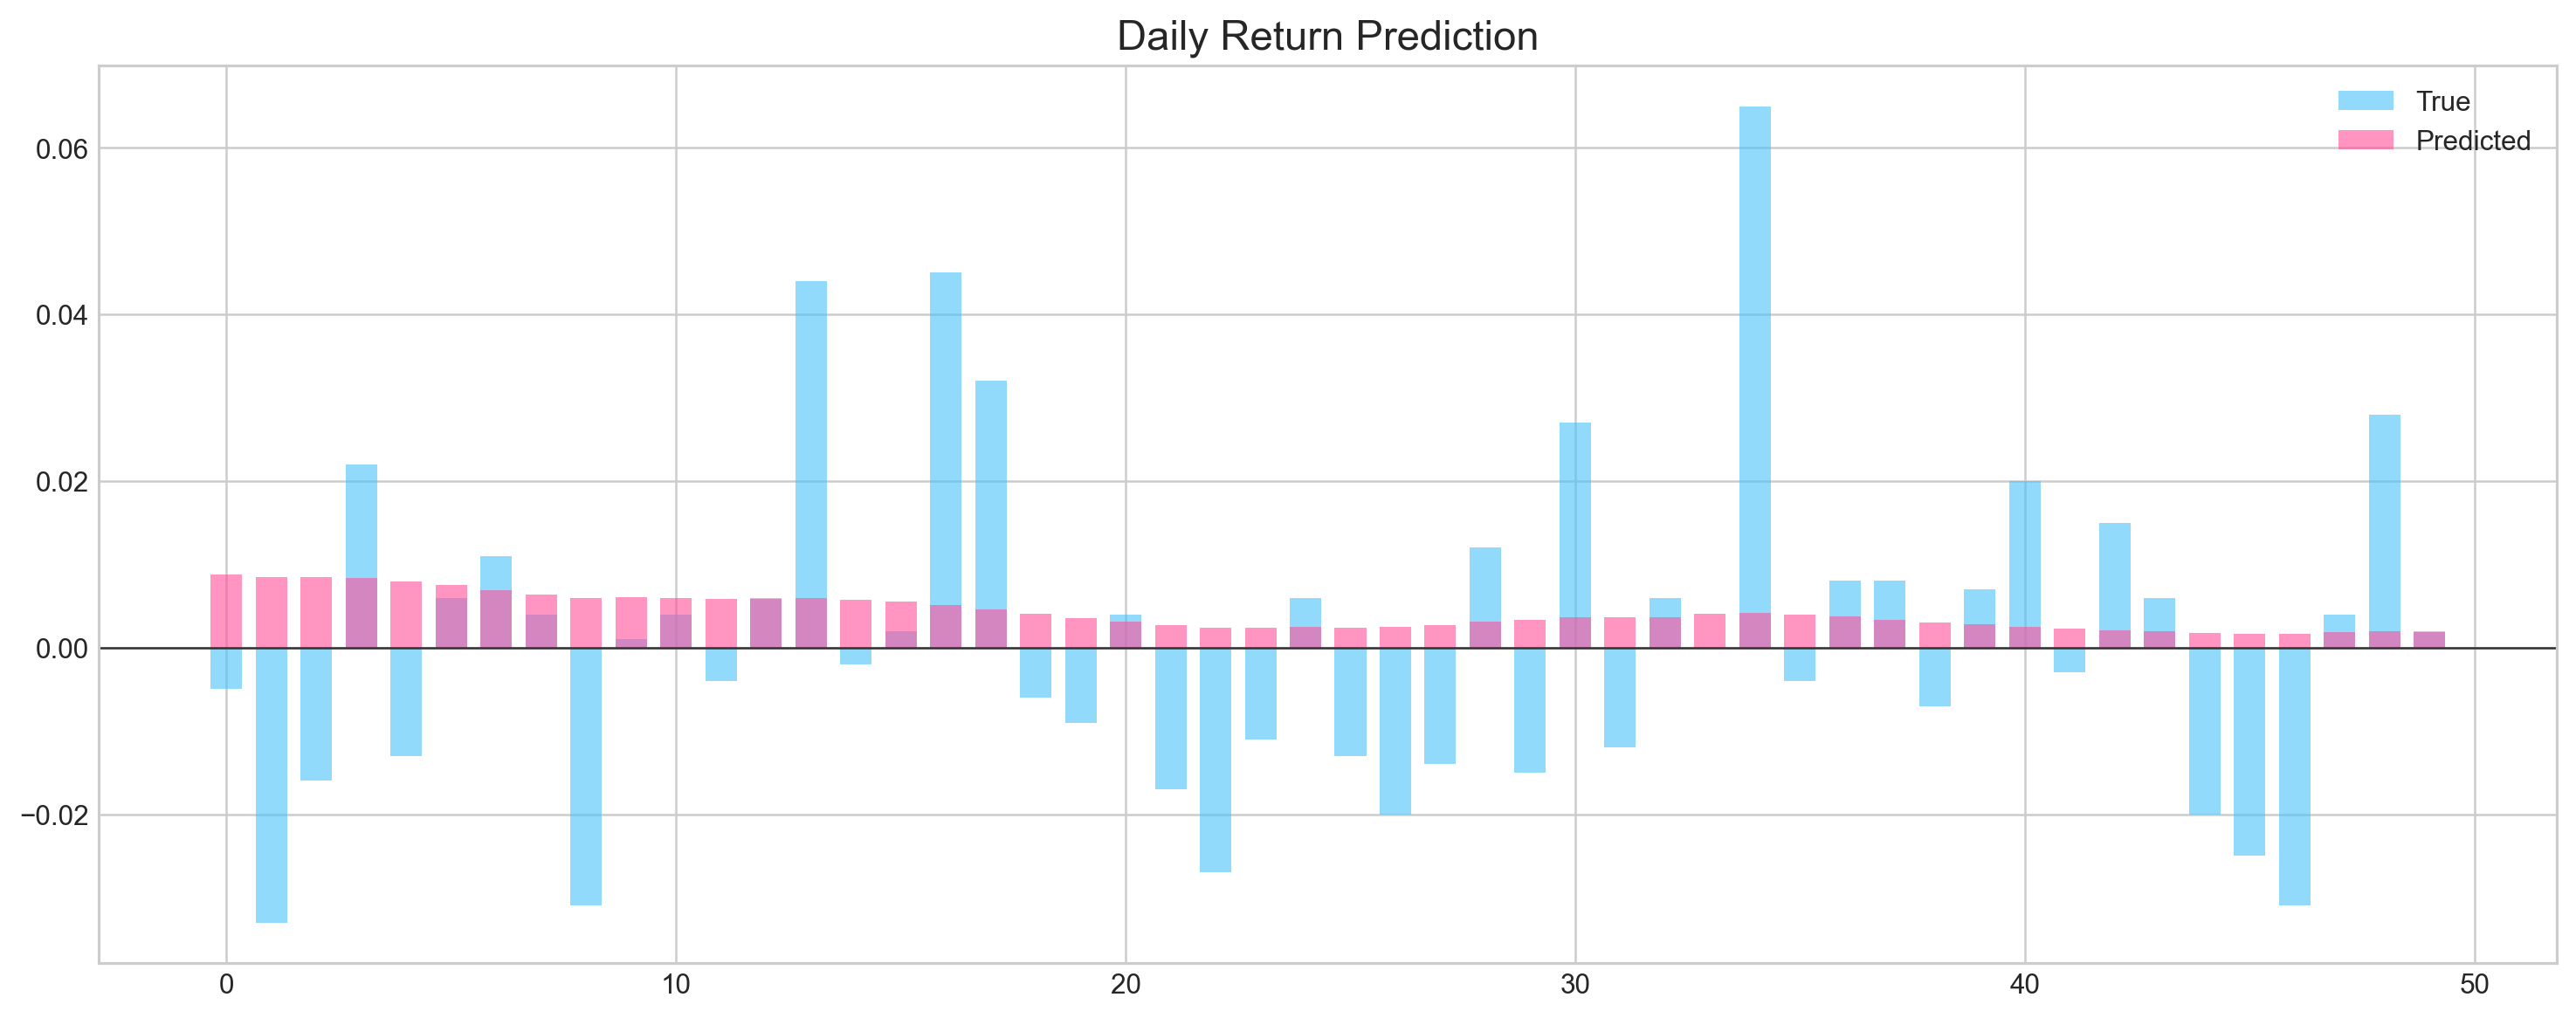

MSE: 0.0003967575683546989
Accuracy: 52%


In [62]:
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=False, n_preds=50, 
                    show_graph=True)

### Conclusion

Network wasn't able to pick up the underlying patterns. Prediction is roughly 50%, which is same as random guess

## 5.2 Convolutional Network

In [84]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

model.add(Conv1D(filters=20, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 20)            700       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
_________________________________________________________________


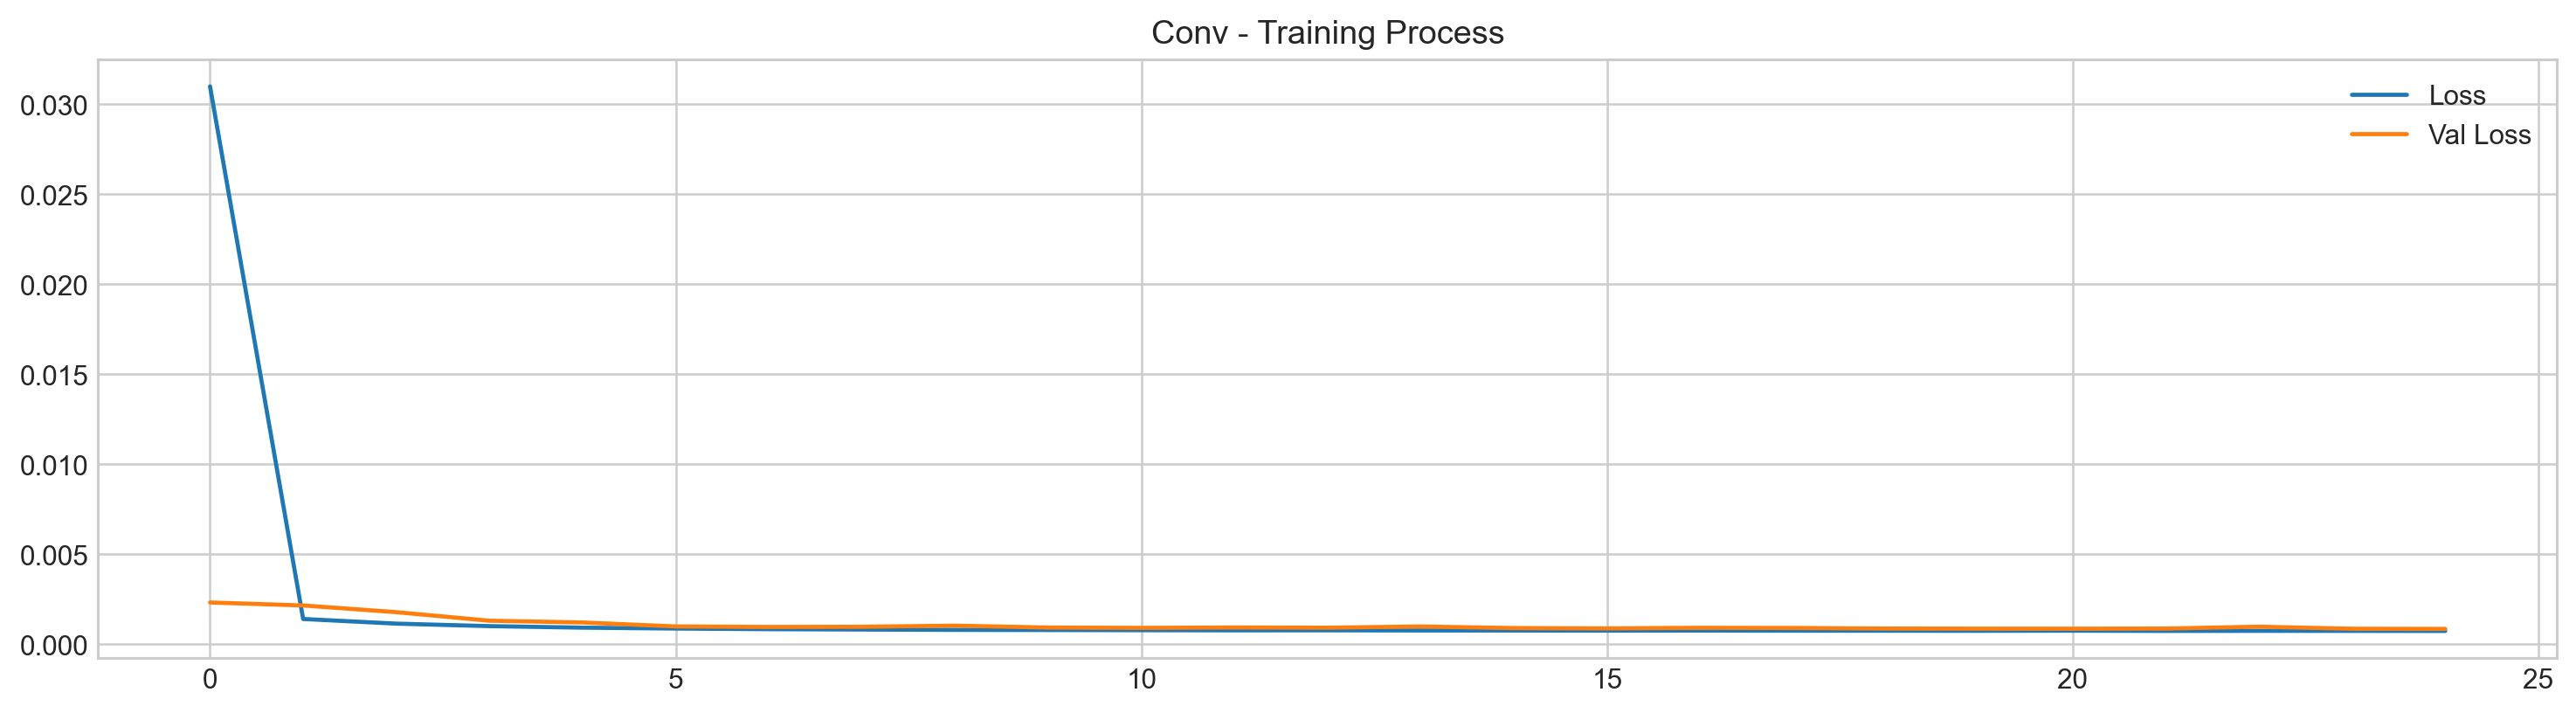

In [86]:
model.fit(X_train, y_train, epochs=25, verbose=1, validation_data=(X_test, y_test), use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.title('Conv - Training Process')
plt.show()

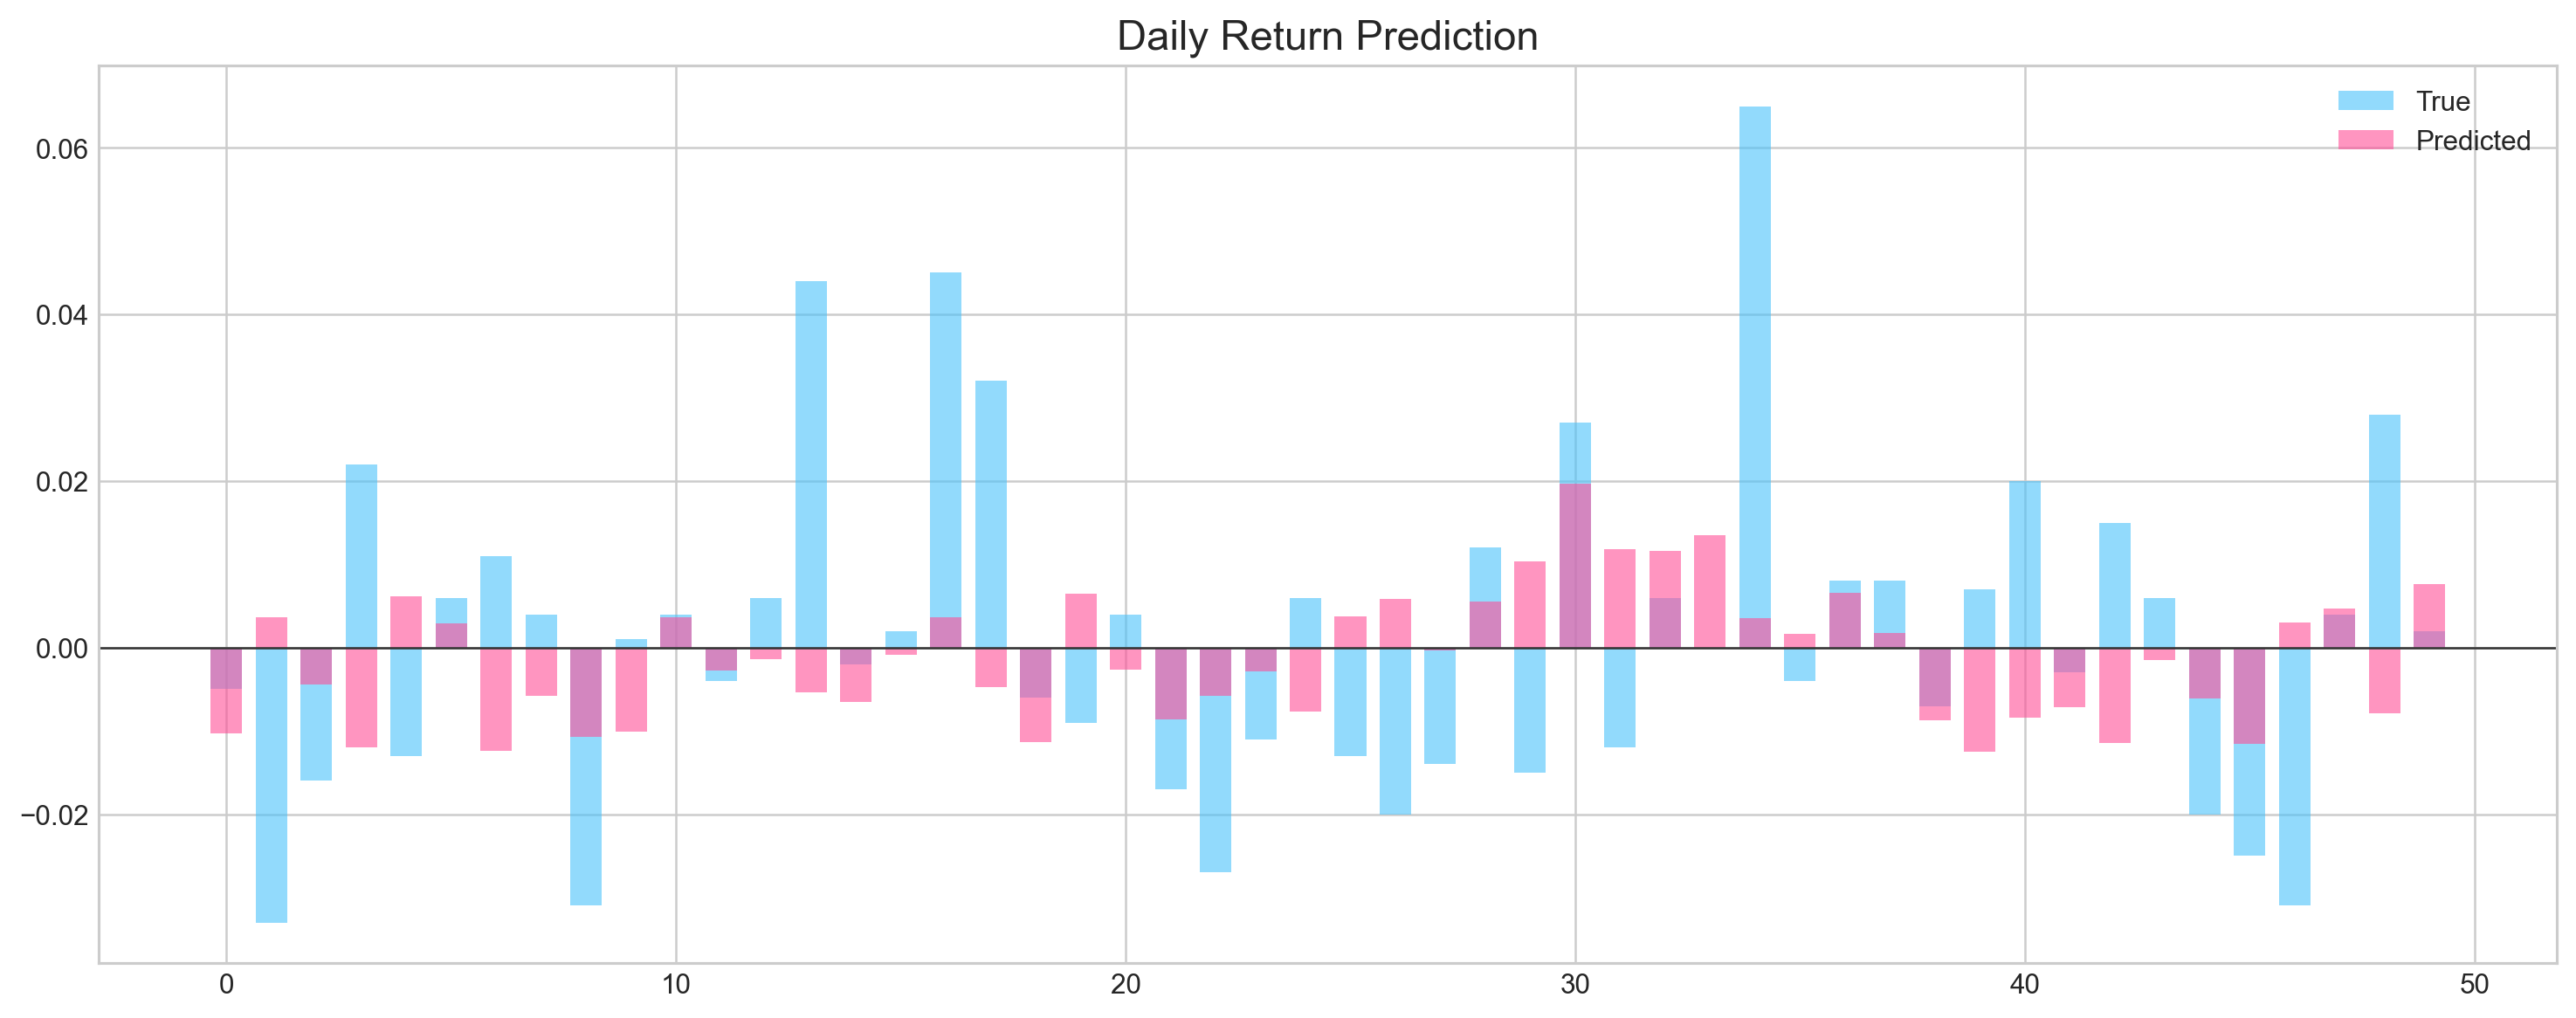

MSE: 0.00044397023943587284
Accuracy: 50%


In [87]:
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=False, n_preds=50, 
                    show_graph=True)

### Conclusion

Network wasn't able to pick up the underlying patterns. Prediction is roughly 50%, which is same as random guess

## 5.3 Combined Stocks Data

Training on 18 different stocks.

In [88]:
all_stocks = pd.concat(stocks,ignore_index=True)

In [89]:
scaled_all = functions.scale(all_stocks, scale=(0,1))

n_steps = 21
X_train, y_train, X_test, y_test = functions.split_sequences(
                        scaled_all.to_numpy()[:-1], 
                        all_stocks['Return'].shift(-1).to_numpy()[:-1], n_steps, split=True, ratio=0.8)

In [92]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(Conv1D(filters=500, kernel_size=10, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

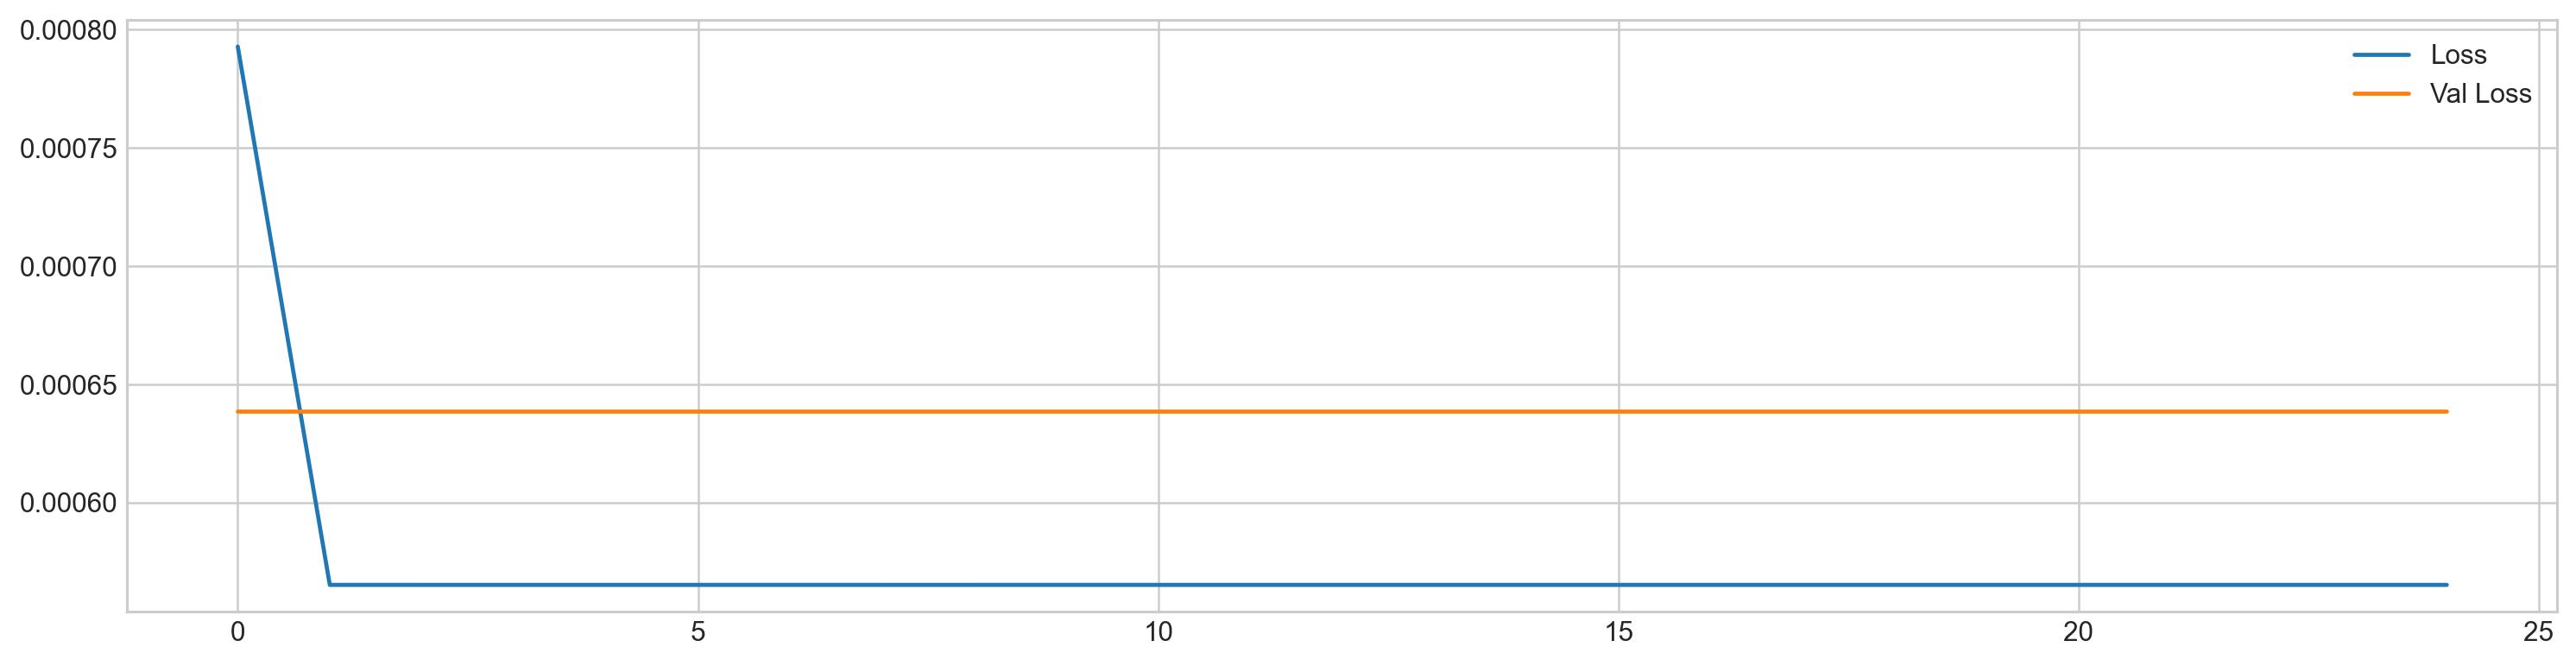

In [93]:
model.fit(X_train, y_train, epochs=25, verbose=0, validation_data=(X_test, y_test), use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.show()

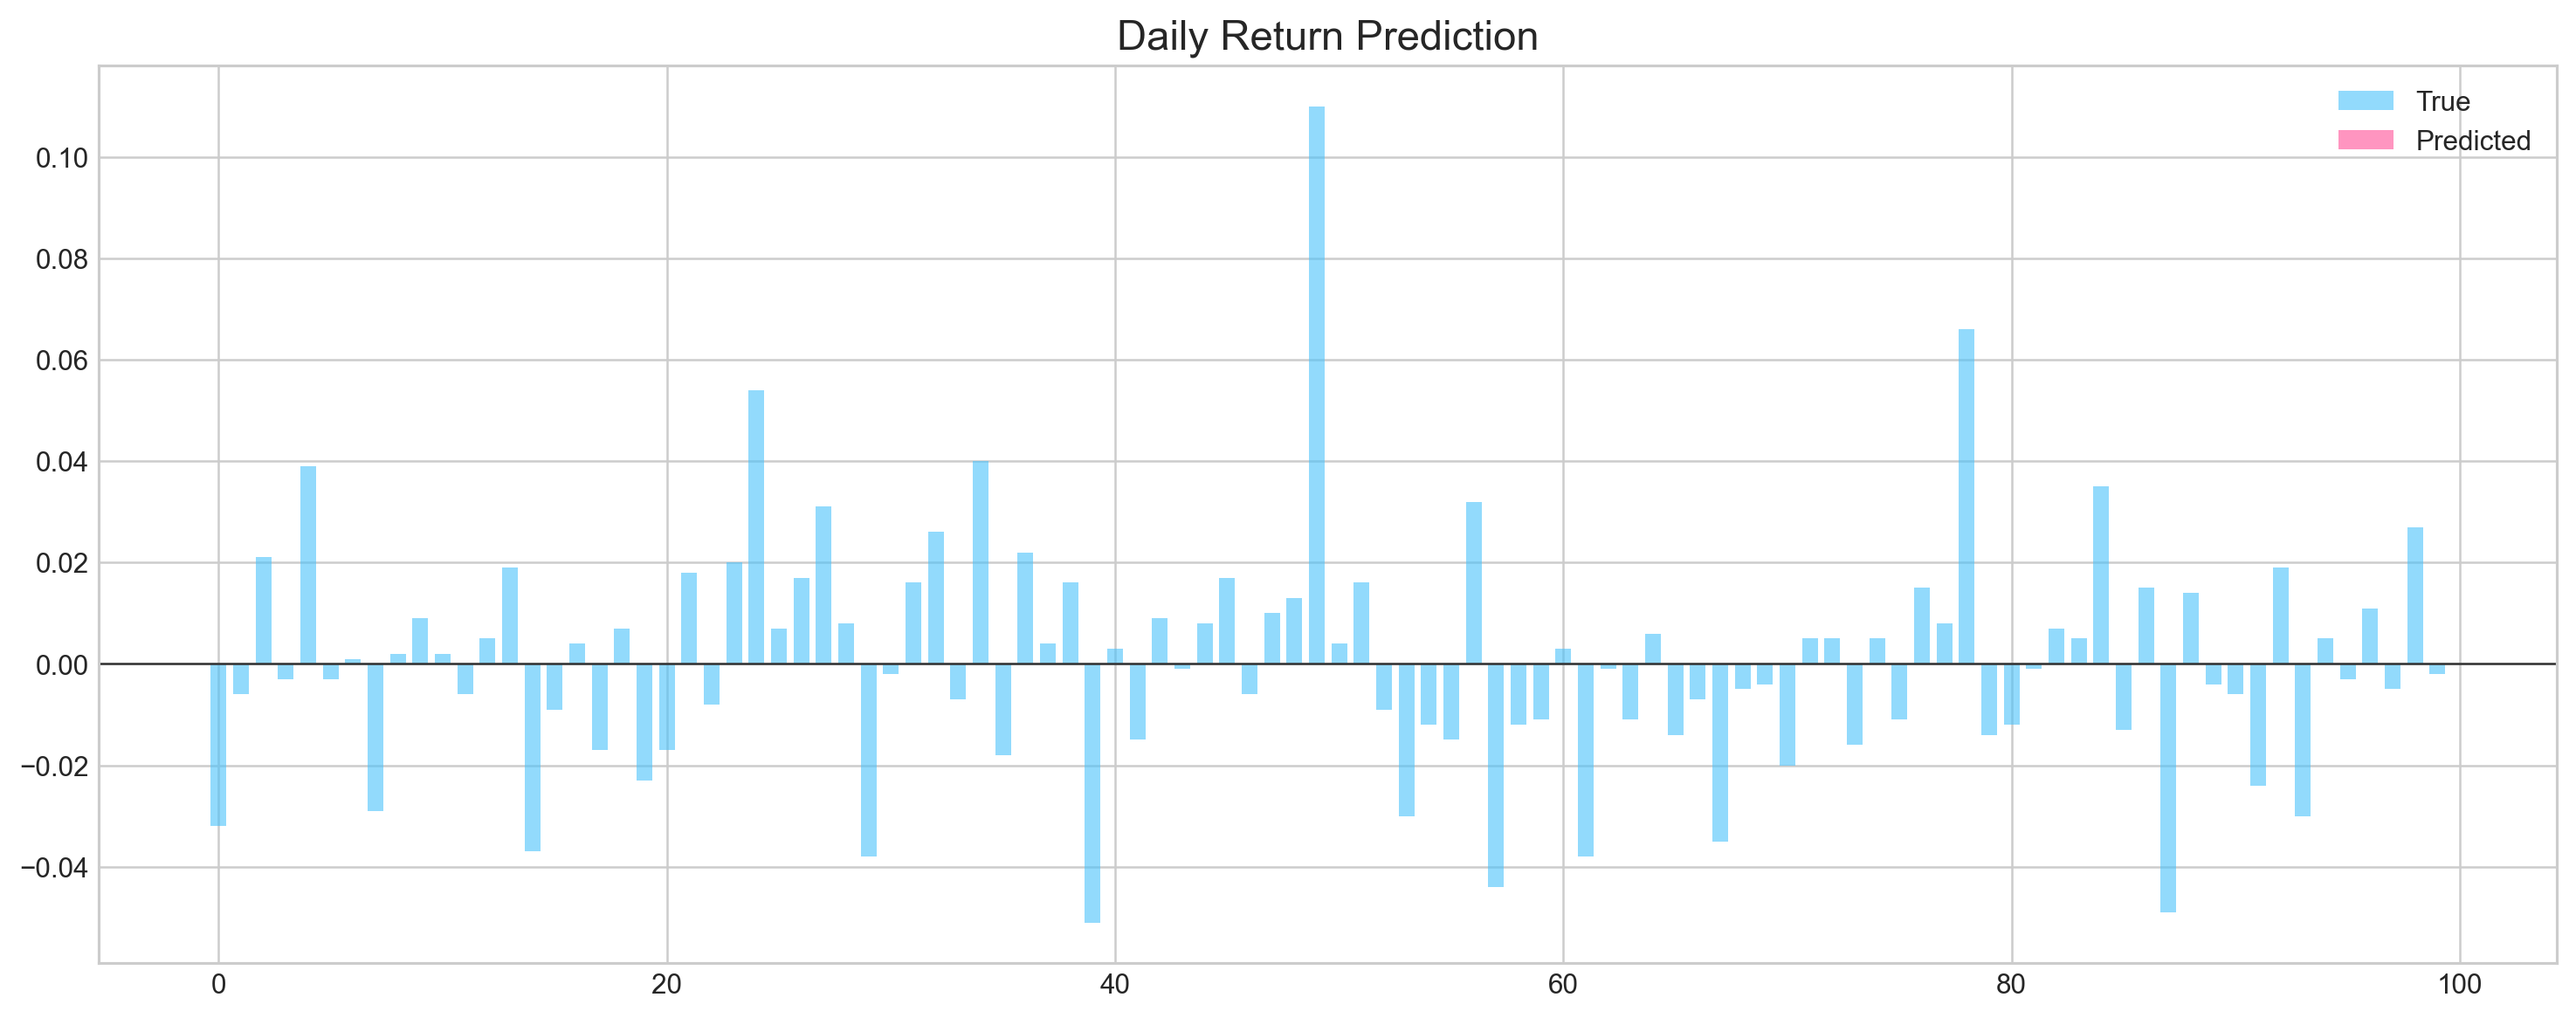

MSE: 0.0005376499918300688
Accuracy: 50%


In [94]:
# Evaluation
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=True, n_preds=100, 
                    show_graph=True)

## 5.4 Bayesian Optimization

In [99]:
def create_model(d1, d2, filters, pool, kernel):
    keras.backend.clear_session()
        
    d1 = int(d1)
    d2 = int(d2)
    filters = int(filters)
    kernel = int(kernel)
    pool = int(pool)
    
    n_steps = X_train.shape[1]
    n_features = X_train.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=pool))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(d2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(X_train, y_train, epochs=4, verbose=0, validation_data=(X_test, y_test), use_multiprocessing=True)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [100]:
def bayesian_optimization():    

    pbounds = {
        'filters': (1, 10), 
        'd1': (160, 250), 
        'd2': (10, 40), 
        'kernel': (2,10), 
        'pool': (2, 10)
    }

    optimizer = BayesianOptimization(
        f = create_model,
        pbounds = pbounds,
        random_state = 1,
        verbose = 2
    )
    optimizer.maximize(init_points=5, n_iter=5)
    print(optimizer.max)

In [101]:
n_steps = 21
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

X_train, \
y_train, \
X_test, \
y_test = functions.split_sequences(
                        
    scaled_tsla.to_numpy()[:-1], 
    stocks['tsla'].Return.shift(-1).to_numpy()[:-1], 
    n_steps, 
    split=True, 
    ratio=0.8
)

In [102]:
bayesian_optimization()

|   iter    |  target   |    d1     |    d2     |  filters  |  kernel   |   pool    |
-------------------------------------------------------------------------------------
|  1        |  0.000688 |  197.5    |  31.61    |  1.001    |  4.419    |  3.174    |
|  2        |  0.000762 |  168.3    |  15.59    |  4.11     |  5.174    |  6.311    |
|  3        |  0.000687 |  197.7    |  30.56    |  2.84     |  9.025    |  2.219    |
|  4        |  0.000771 |  220.3    |  22.52    |  6.028    |  3.123    |  3.585    |
|  5        |  0.000689 |  232.1    |  39.05    |  3.821    |  7.539    |  9.011    |
|  6        |  0.000695 |  221.9    |  11.94    |  8.202    |  2.313    |  2.216    |
|  7        |  0.000702 |  218.5    |  26.73    |  4.605    |  3.556    |  5.906    |
|  8        |  0.000874 |  221.4    |  23.31    |  6.062    |  3.239    |  4.893    |
|  9        |  0.000716 |  221.0    |  24.1     |  5.278    |  2.913    |  3.619    |
|  10       |  0.000708 |  221.5    |  22.65    |  5.4

In [103]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=9, kernel_size=5, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=9))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

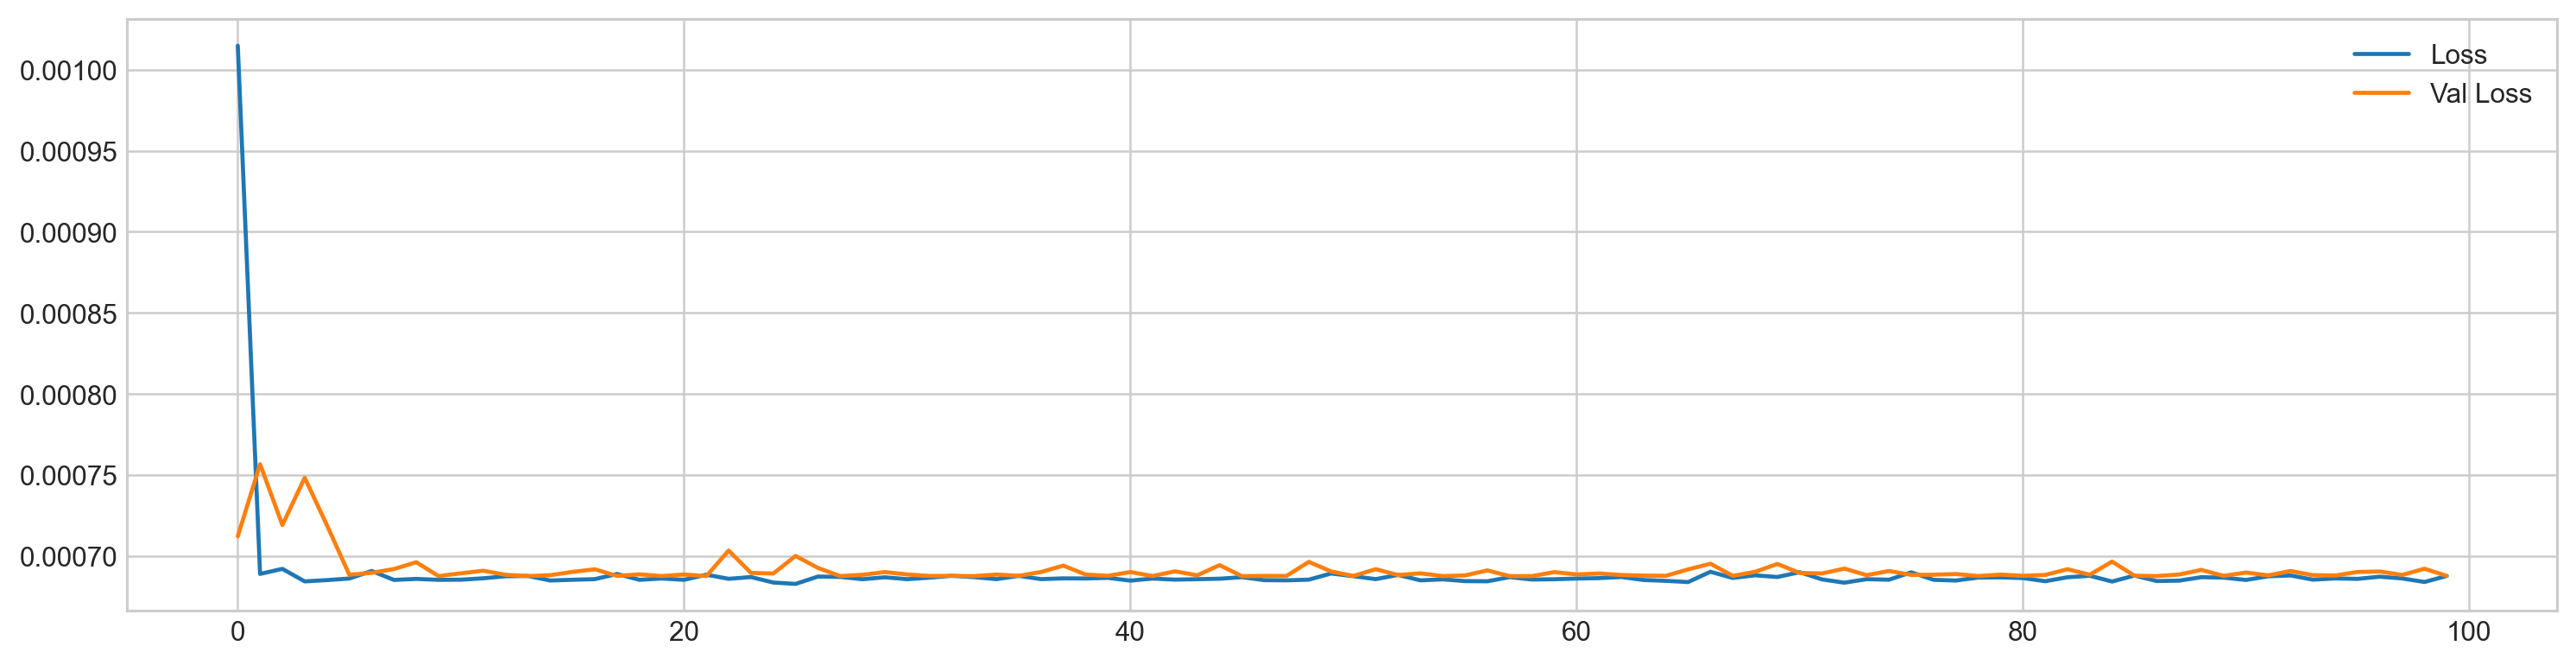

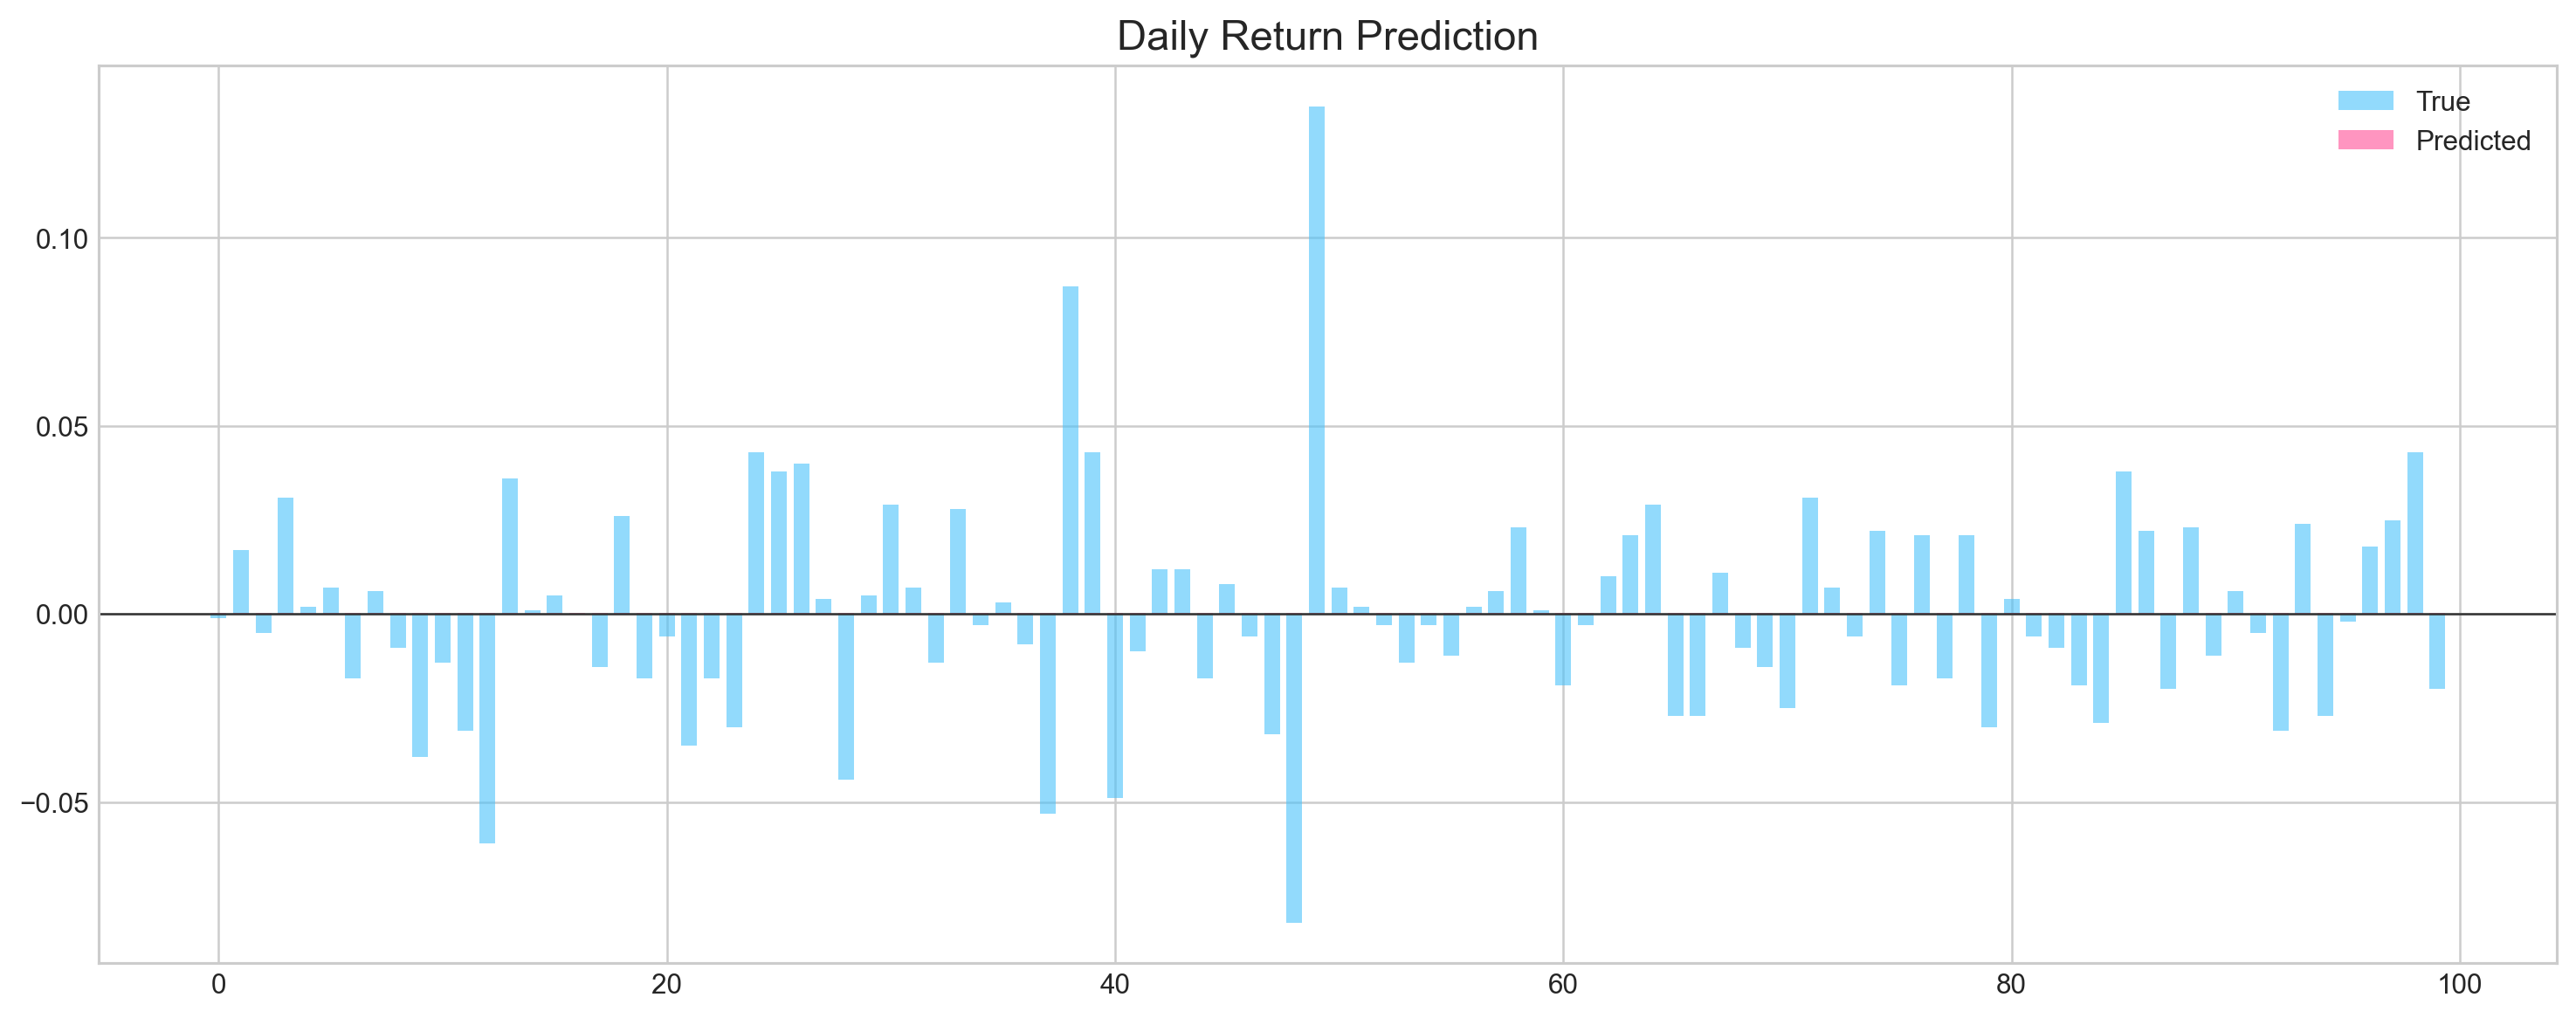

MSE: 0.0008209771582292502
Accuracy: 48%


In [104]:
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test), use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.show()

# Evaluation
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=True, n_preds=100, 
                    show_graph=True)

### Conclusion

Bayesian optimization didn't improve accuracy. Results are similar to the previous networks.

# 6. Finding Similar Patterns

Hypothesis behind this idea is simple: can patterns (sequences) found train set be used to predict patterns in test set? Pattern is a sequence of daily stock returns presented as binary values (0 - if return is negative, 1 - if return is positive). Example of sequence: [0, 1, 1, 0, 1, 0, 0, 1, 0]. The process can be broken down into several steps:
1. Split data into train and test sets
2. Pick first pattern (with length of 9 days) from test set and collect similar patterns in train set
3. Compare 10th day of train patterns with 10th day of test pattern, save result
4. Repeat process for the rest of the patterns in test set

## Example

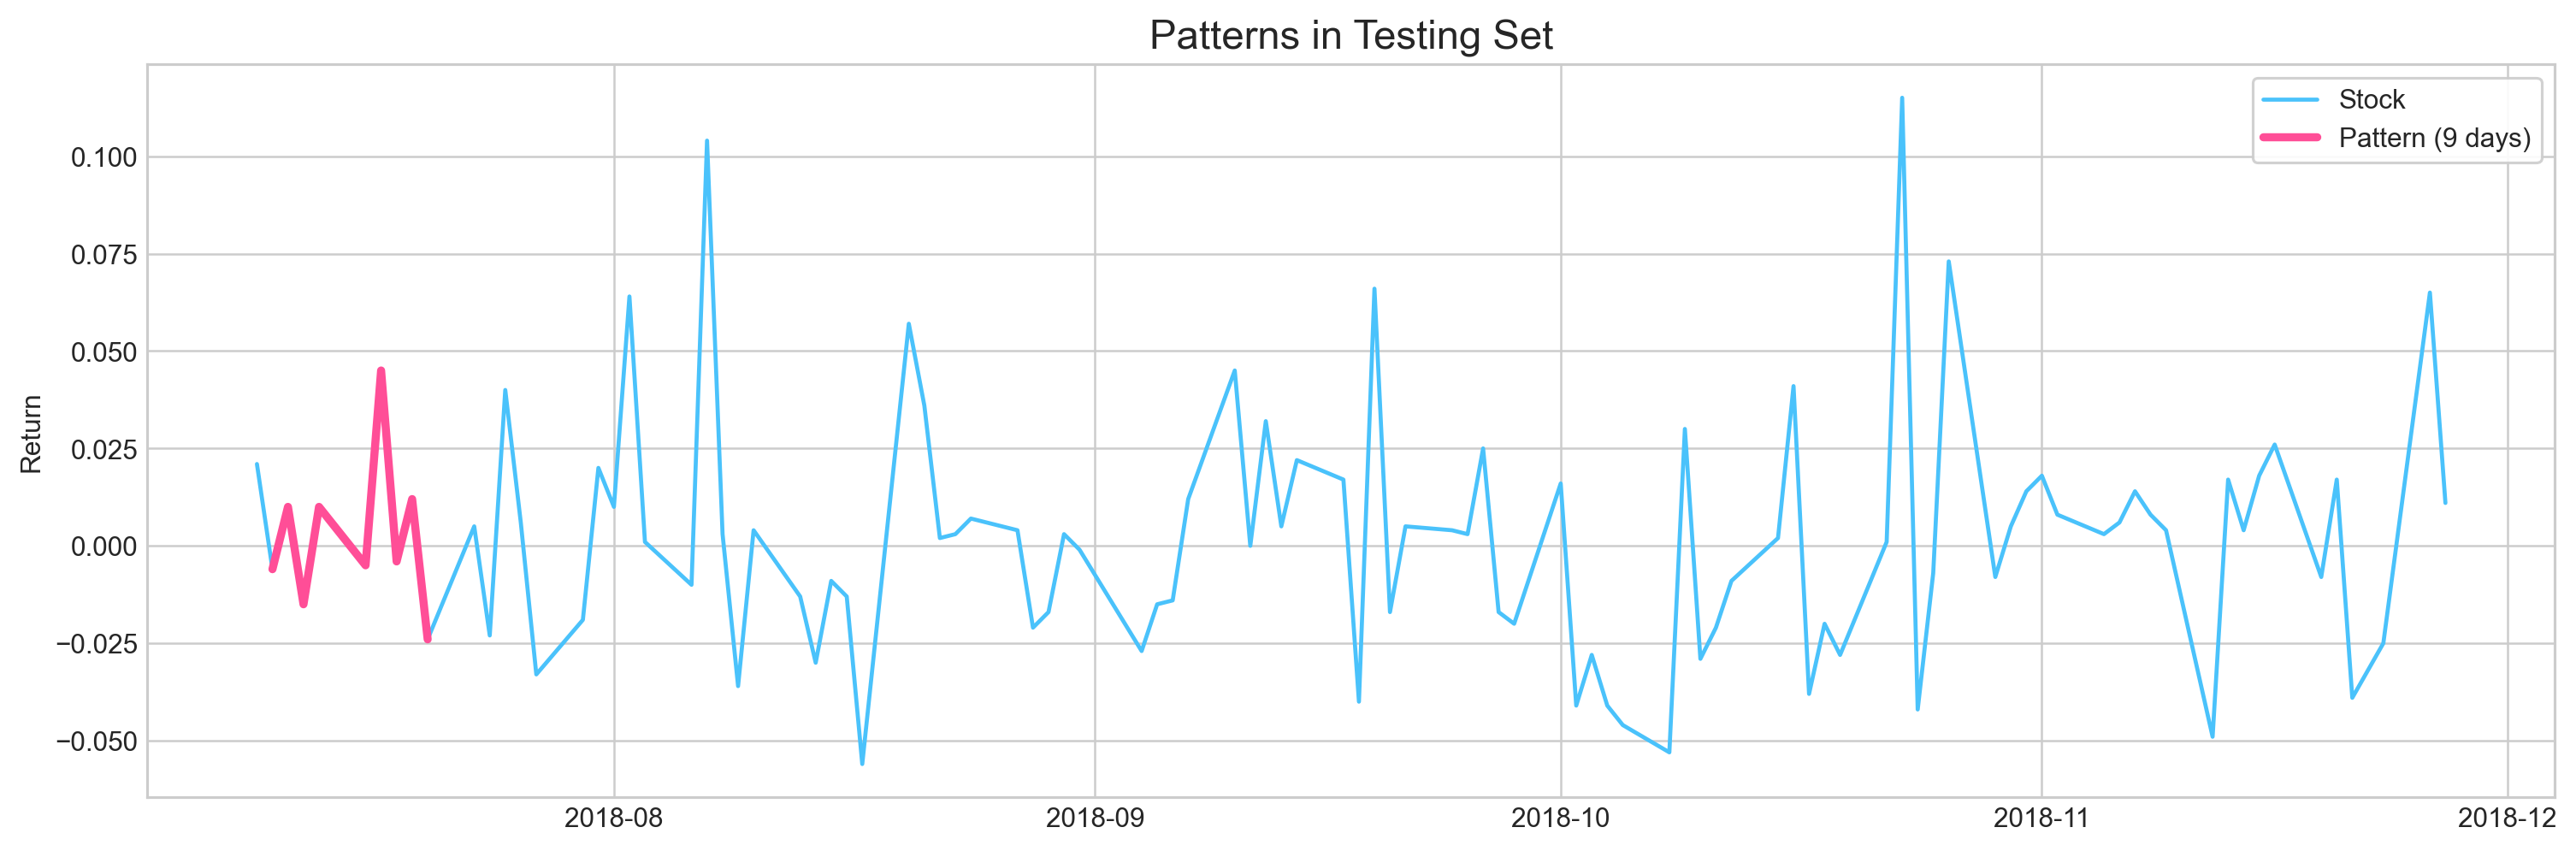

In [105]:
plt.figure(figsize=(16,5))
plt.style.use('seaborn-whitegrid')
plt.plot(stocks['tsla'][2000:2100].Return, label='Stock', c='#4ac2fb')
plt.plot(stocks['tsla'][2001:2010].Return, lw=3, label='Pattern (9 days)', c='#ff4e97')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Patterns in Testing Set', fontSize=15)
plt.ylabel('Return')
plt.show()

## Evaluating Pattern Matching Technique

In [106]:
binary_return = functions.binary(stocks['tsla'].Return.values)

binary_train = binary_return[:2000]
binary_test = binary_return[2000:]

step = 9 # length of the pattern we're trying to find (ex.: [0,0,1,0,1,1,0,1,0])
check_step = step + 1 # value we're trying to predict (value that goes after pattern [0 or 1])
total_predictions = []

# Here we loop through test set (or part of it)
# and pick a pattern with length 'step'
for i in range(10):    
    if i + check_step >= len(binary_test):
        break    
    found_patterns = []    
    sample = binary_test[i:i+step]
    sample_check = binary_test[i+check_step]
    
    # Looking for patterns in training set
    # that matches with pattern from testing set
    for j in range(len(binary_train)-check_step):                          
        if accuracy_score( binary_train[j:j+step], sample ) == 1.0:
            found_patterns.append(i)
            
    p = []
    prediction = None
    if len(found_patterns) != 0:
        for k in found_patterns:
            p.append( binary_train[k+check_step] )
        
        prediction = sum(p)/len(p)
        if sample_check == prediction:
            total_predictions.append(1)
        else:
            total_predictions.append(0)
    
accuracy = sum(total_predictions)/len(total_predictions)
print('Accuracy:', accuracy)

Accuracy: 0.7


## Similar Patterns to the Example

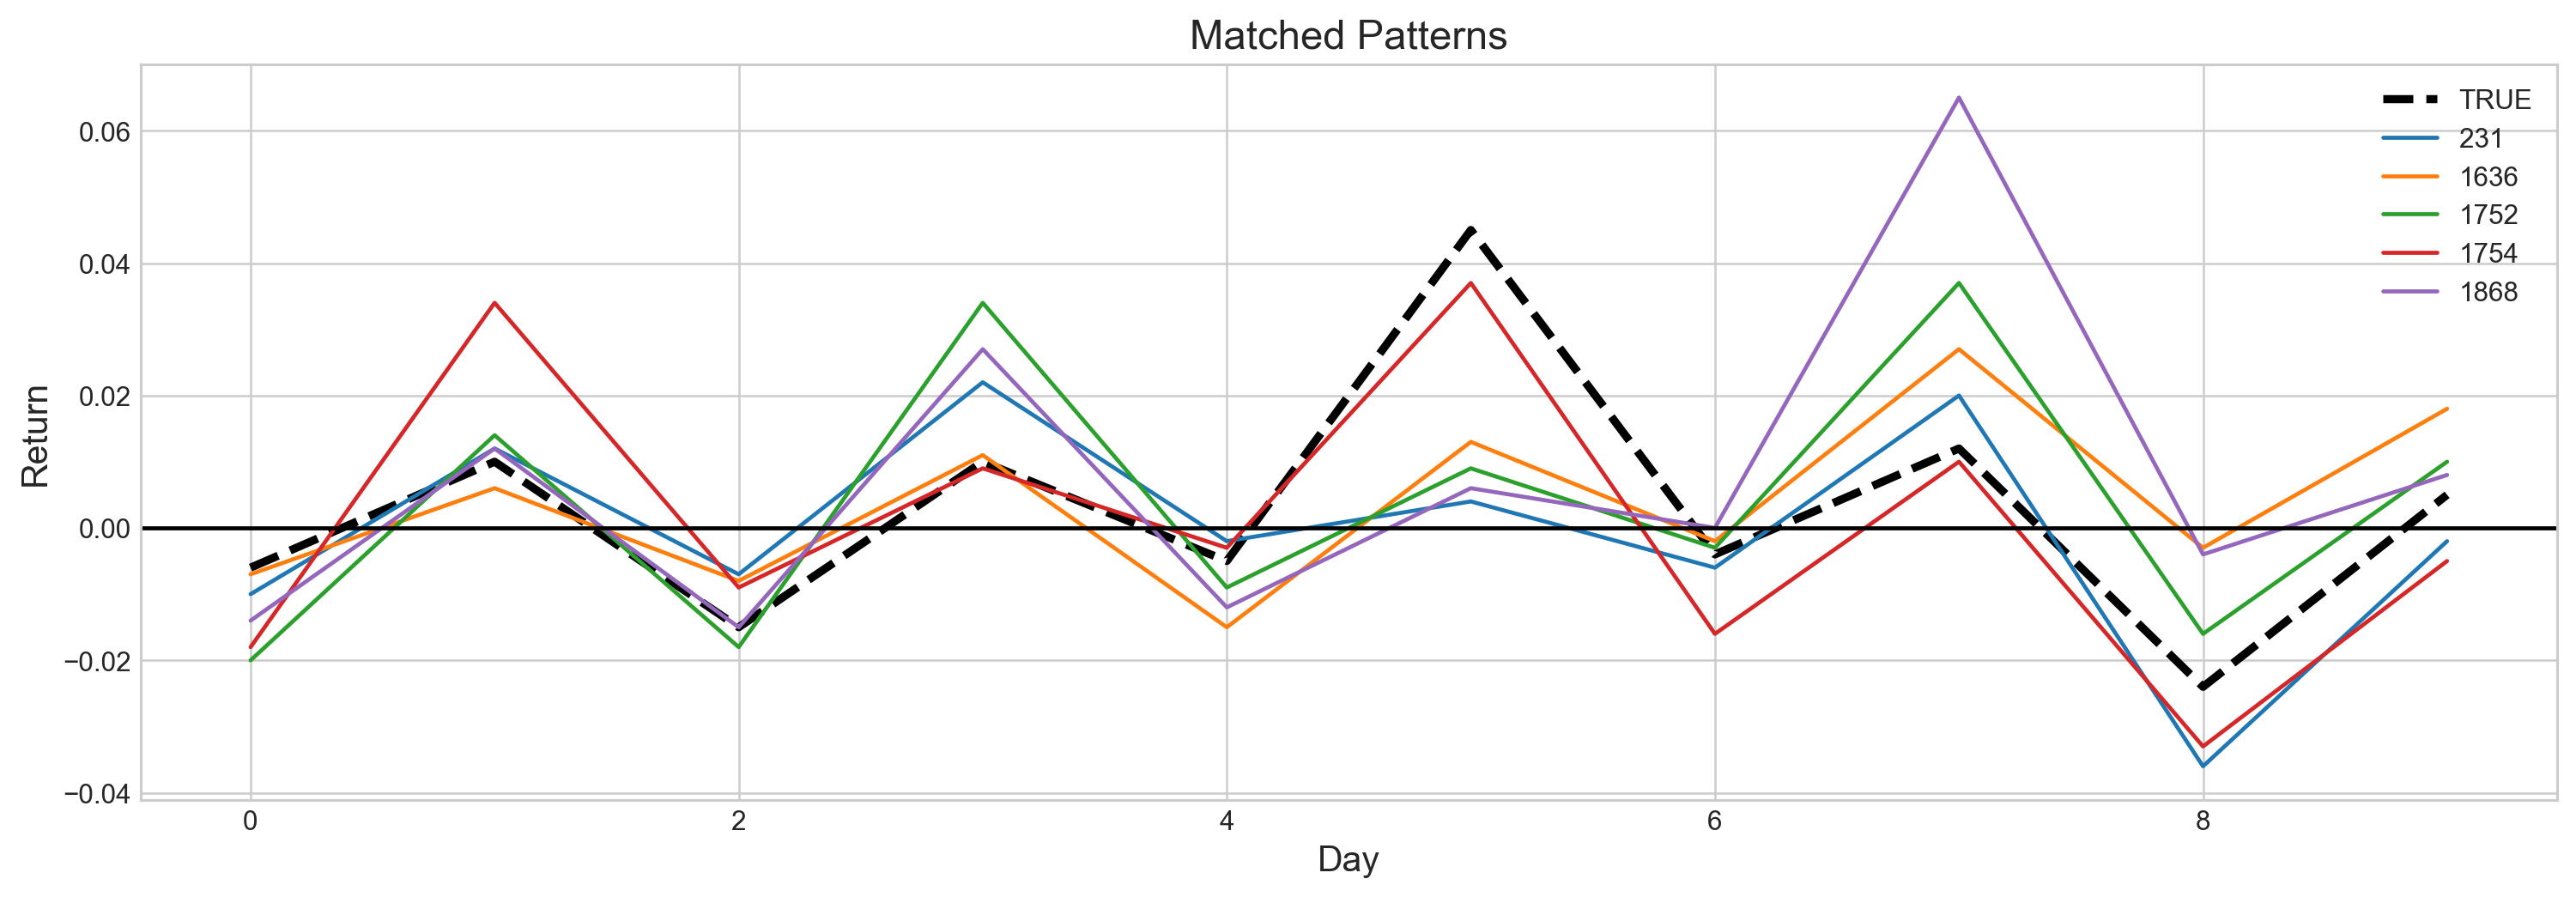

In [108]:
start = 1
window = 9
a = []

sample = binary_test[start:start+window]
for i in range(len(binary_train)-window):
    if accuracy_score(binary_train[i:i+window], sample) == 1.0: a.append(i)

plt.figure(figsize=(16,5))
plt.plot(stocks['tsla'][2000+start:start+2010].Return.values, label='TRUE', ls='--', lw=3, c='k')
[plt.plot(stocks['tsla'].Return[i:i+10].values, label=i) for i in a]
plt.axhline(0, c='k')
plt.title('Matched Patterns', fontSize=15)
plt.xlabel('Day', fontSize=13)
plt.ylabel('Return', fontSize=13)
plt.legend()
plt.show()

## Visual Comparison

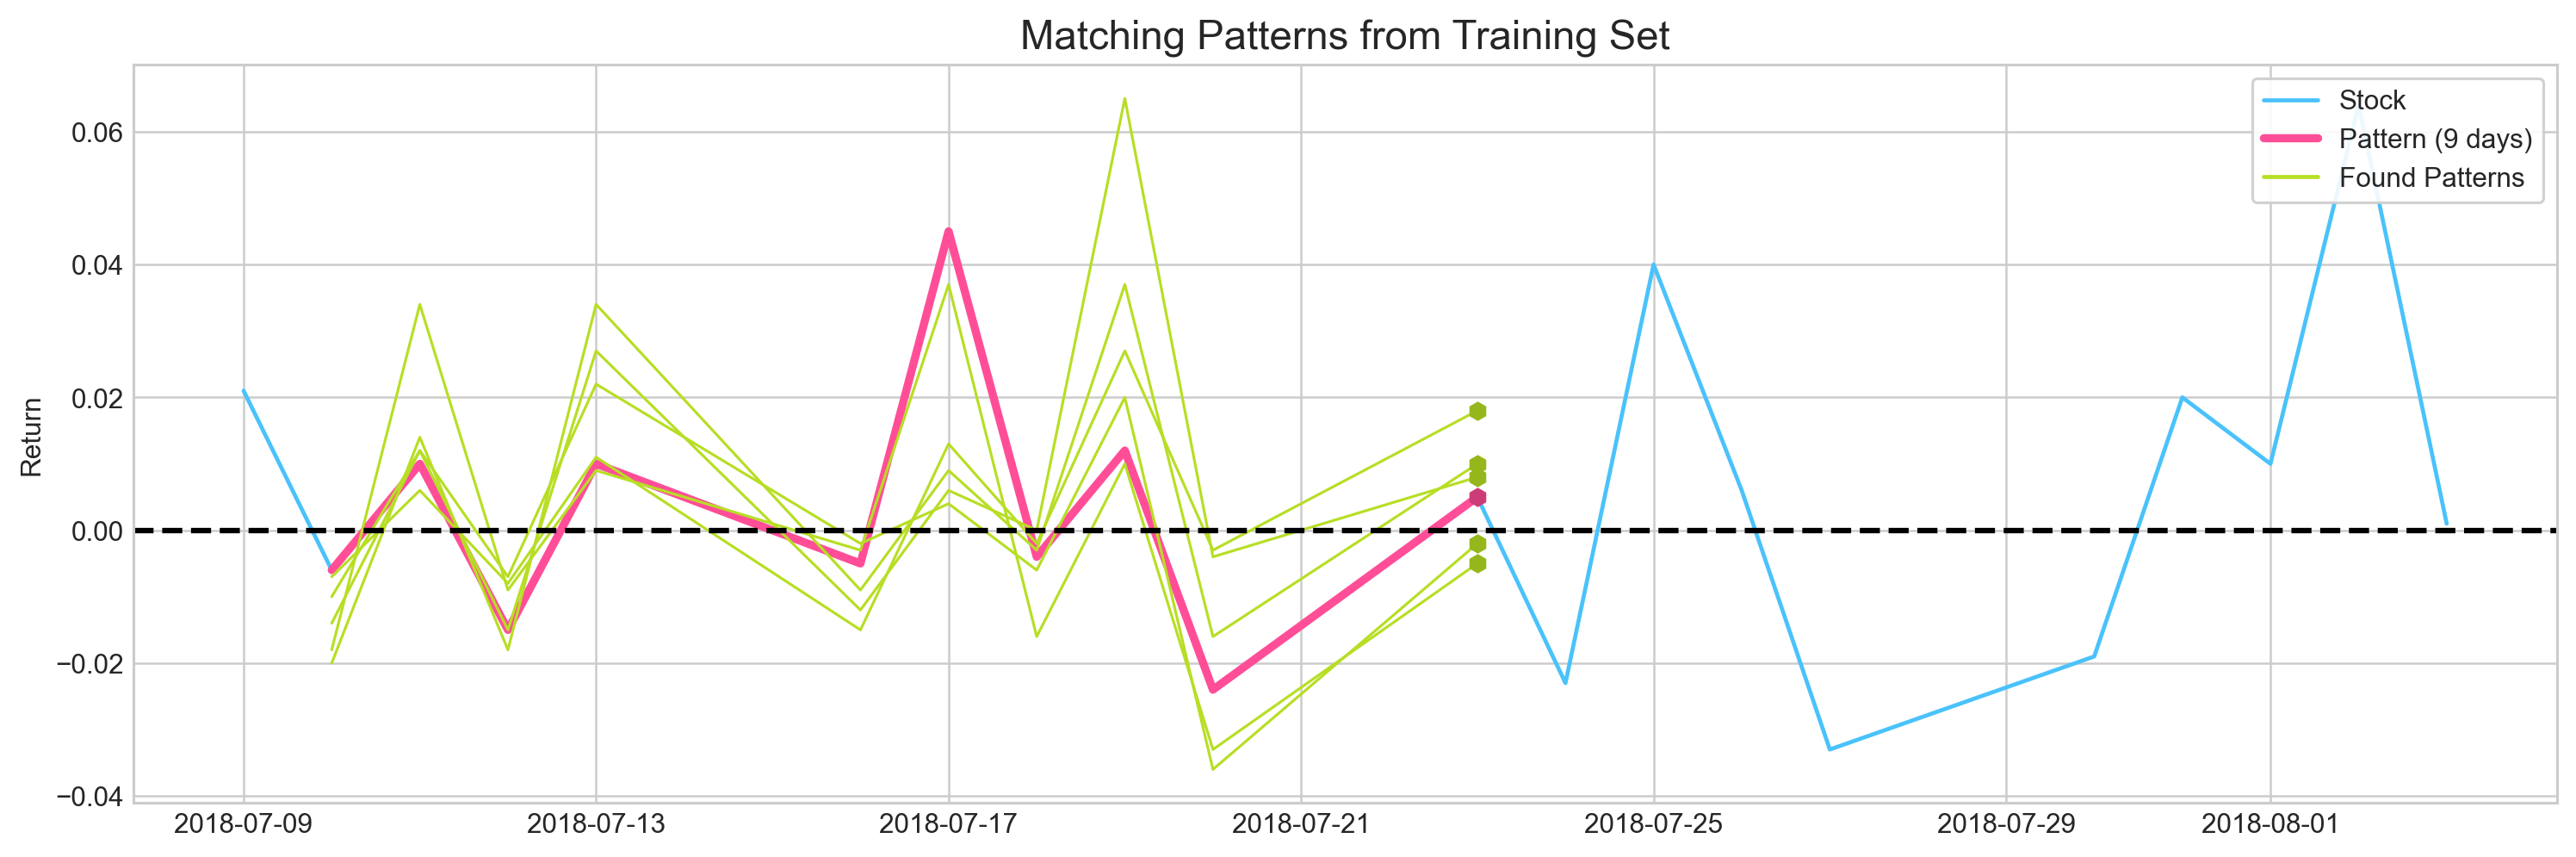

In [109]:
indexes = stocks['tsla'][2001:2011].Return.index

plt.figure(figsize=(16,5))
plt.plot(stocks['tsla'][2000:2020].Return, label='Stock', c='#4ac2fb')
plt.plot(stocks['tsla'][2001:2011].Return, lw=3, label='Pattern (9 days)', c='#ff4e97')
plt.plot(stocks['tsla'][2010:2011].Return, 'h', c='#cc3d78')

for i in a:
    ret = stocks['tsla'][i:i+10].set_index(indexes).Return
    plt.plot(ret, lw=1, c='#b7de24')
    plt.plot(ret[9:], 'h', c='#96b71c')
    #print(ret[9:])

plt.plot([],[], label='Found Patterns', c='#b7de24') # dummy plot for legend

plt.axhline(0, c='k', lw=2, ls='--')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Matching Patterns from Training Set', fontSize=15)
plt.ylabel('Return')
plt.show()

### Conclusion

Accuracy varies depends on the section of the train data we're working on. Results are inconsistent, but generally approaching baseline model results.

# 7. Q-Learning

## 7.1 Using MACD to Make Decision

Number of Trades: 18
Time Frame: 343 days
Profit: $-1760.04 | -11.73%


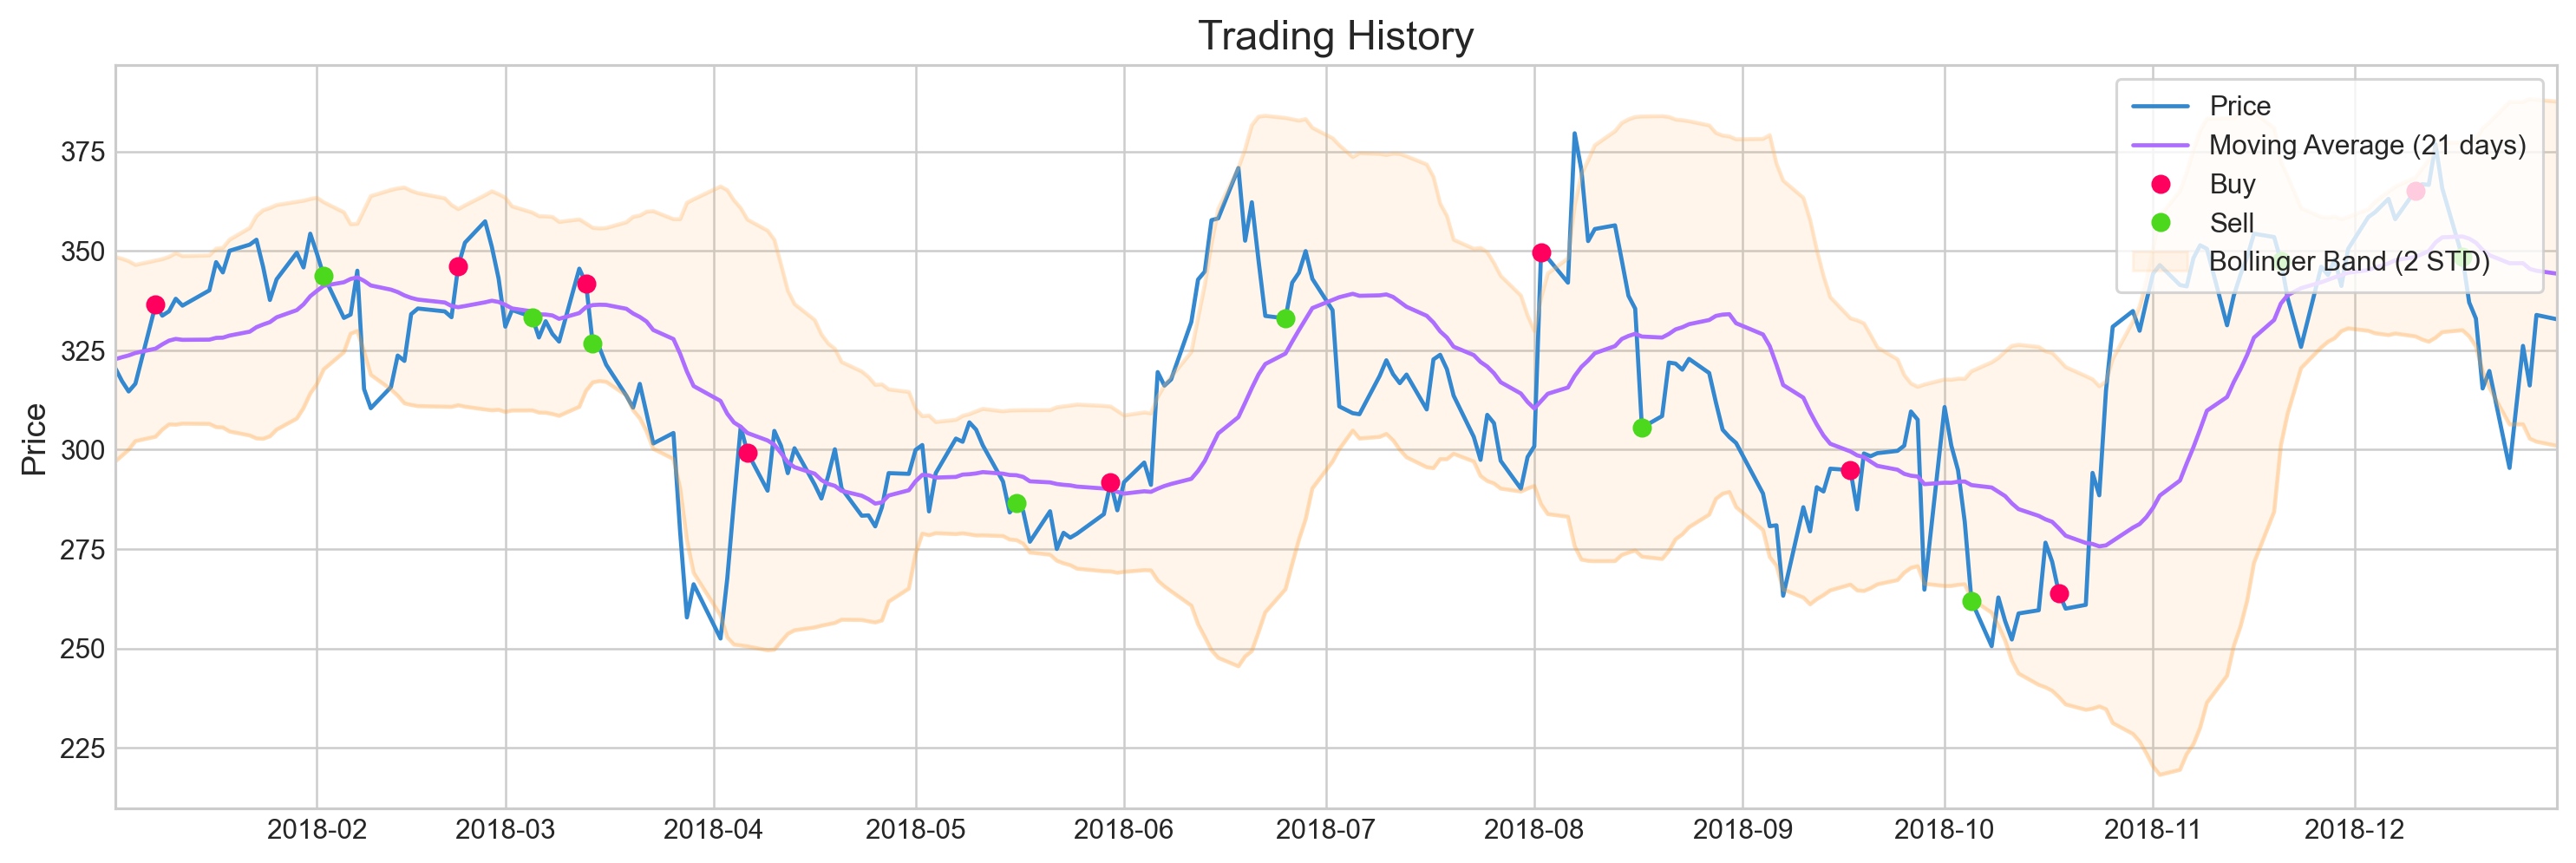

In [110]:
profit, trades = functions.macd_trading(stocks['tsla'].loc['2018':'2018'])

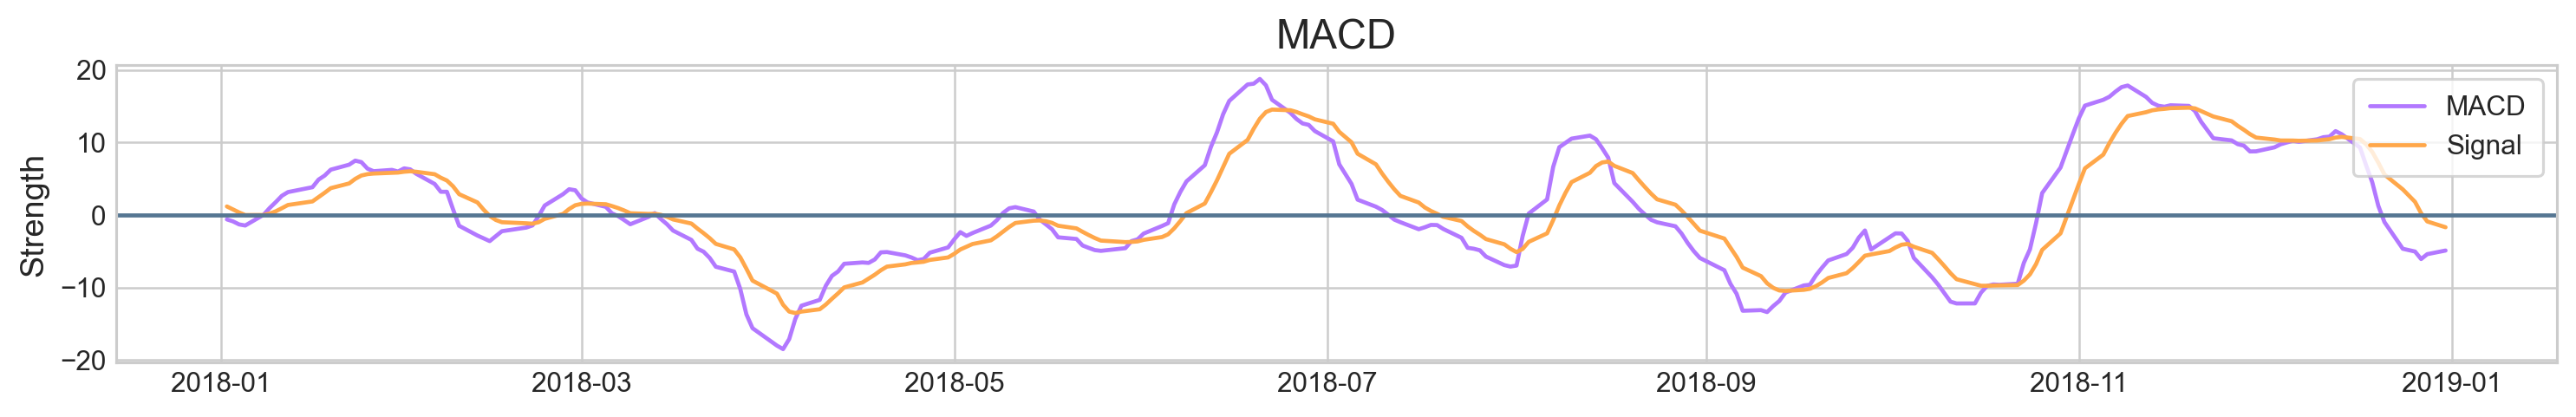

In [111]:
plotting.macd(stocks['tsla'].loc['2018':'2018'])

### Returns

In [112]:
companies = [i for i in stocks]
returns = []
for i in stocks:
    profit, trades = functions.macd_trading(
        stocks[i].loc['2018':'2018'], 
        budget=5000, 
        show_graph=False, 
        show_return=False
    )
    returns.append(round(profit*100 / 5000, 2))

In [113]:
pd.DataFrame({'Company': companies, 'Return (%)': returns}).sort_values(by='Return (%)', ascending=False)

Company  Return (%)
16    twtr       63.33
14    shop        6.32
12    orcl       -1.79
13    qcom       -3.53
9     msft      -10.93
17     vmw      -11.20
2     csco      -12.03
4     ebay      -16.27
0     aapl      -18.76
7      ibm      -23.01
10    nflx      -25.06
8     intc      -25.09
3       ea      -34.87
15    tsla      -37.28
5       fb      -51.98
11    nvda      -62.73
6     goog     -100.00
1     amzn     -100.00

### Conclusion

You're going to lose money if you use MACD 

## 7.2 Using Bollinger Bands to Make Decision

Number of Trades: 19
Time Frame: 316 days
Profit: $15332.70 | 102.22%


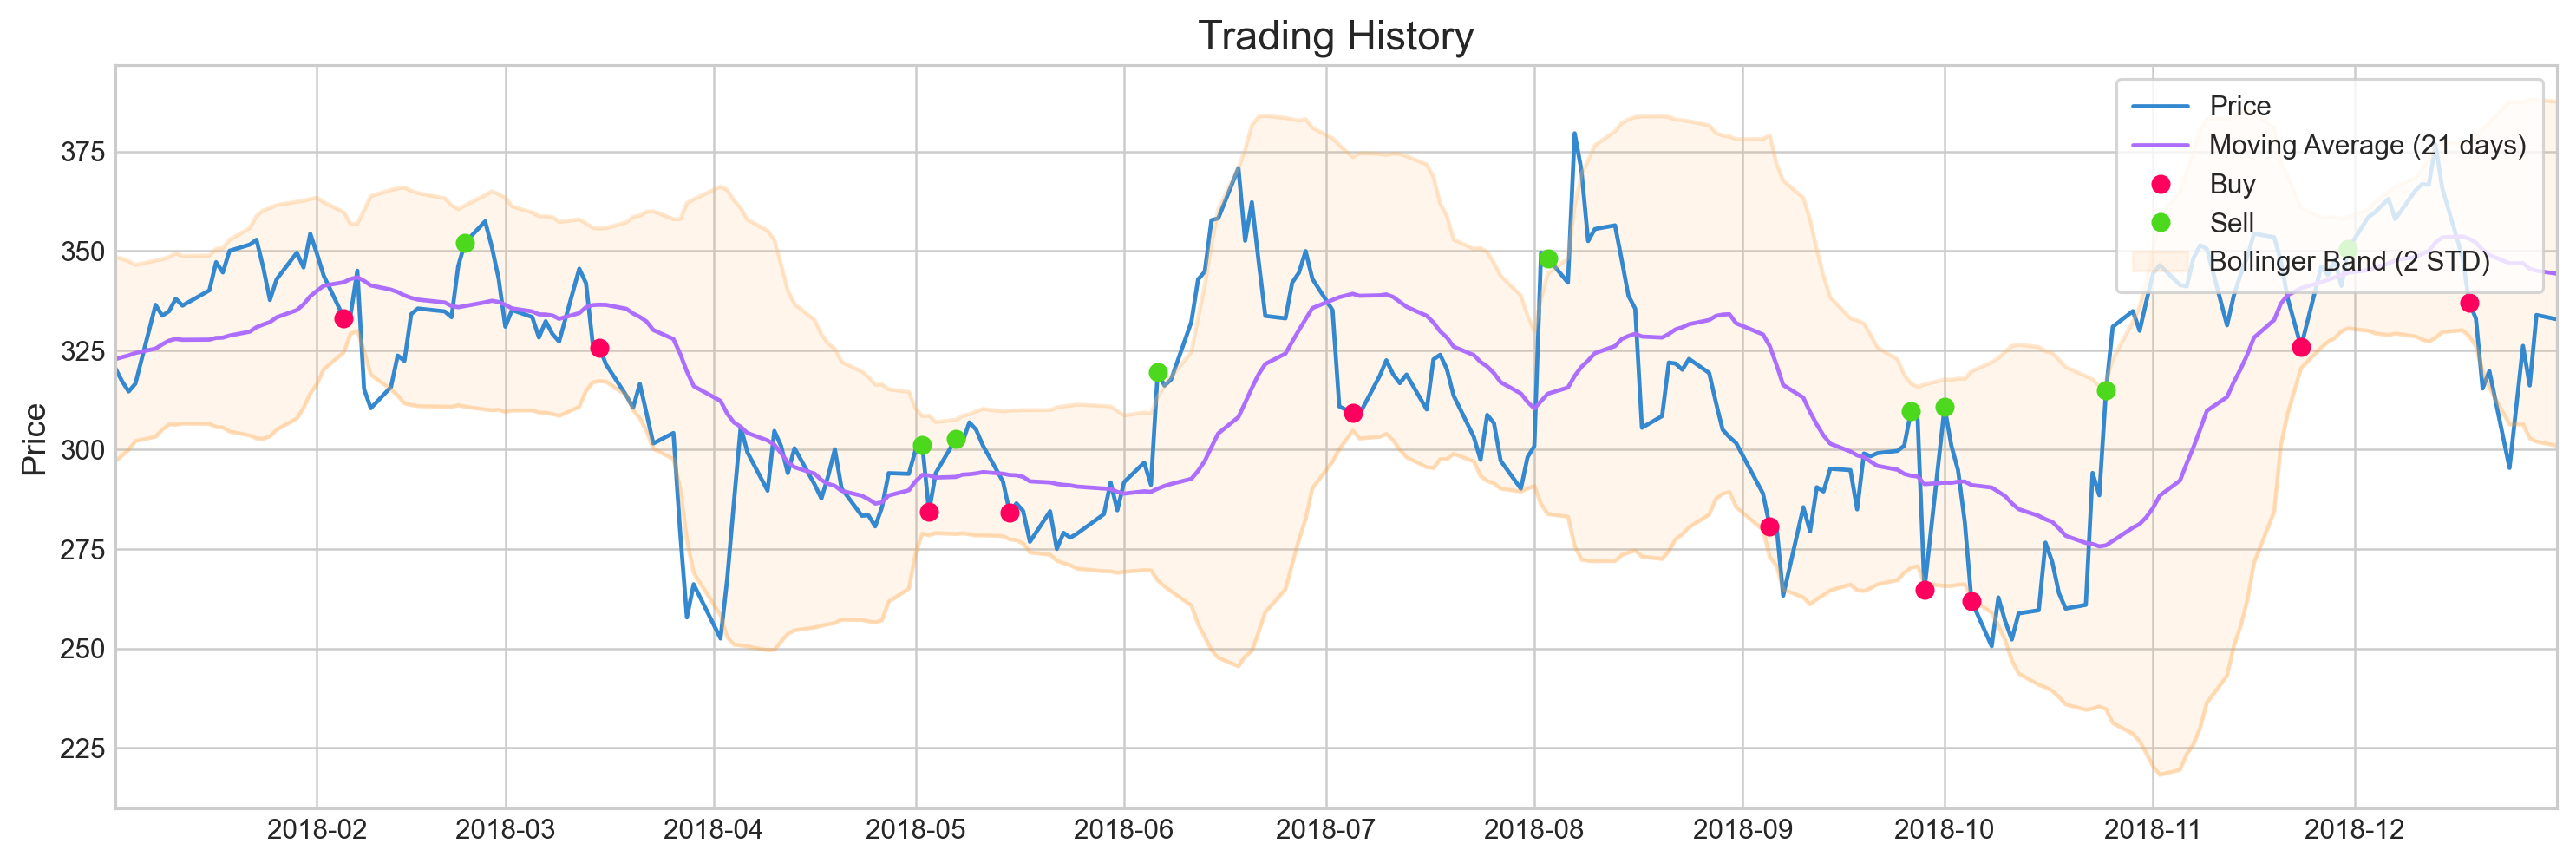

In [114]:
# Tesla
profit, trades = functions.bb_trading(stocks['tsla'].loc['2018':'2018'], u=0.03, l=0.03)

### Returns

In [115]:
companies = [i for i in stocks]
returns = []
for i in stocks:
    profit, trades = functions.bb_trading(
        stocks[i].loc['2018':'2018'], 
        budget=5000, 
        u=0.03, 
        l=0.03, 
        show_graph=False, 
        show_return=False
    )
    returns.append(round(profit*100 / 5000, 2))

# Conclusion

- ARIMA model can't surpass baseline model accuracy due to the historical data stochastic behaviour.
- Convolutional model prone to overfitting, resulting on very good accuracy on training set, and extremely poor accuracy on testing set.
- Recurrent (LSTM) neural network can't learn from training data, averaging on 50% accuracy both on training and testing data
- Bayesian optimization didn't improve accuracy of convolutional network
- Neural Network architecture and complexity doesn't affect results of the model performance
- Predictions based on matching patterns from testing data with patterns from testing didn't surpass 50% accuracy
- **Q-Learning, specifically Bollinger Bands showed good results for short term investment**